In [1]:
import numpy as np
import pandas as pd
#from ase import units
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde, linregress, t
from sklearn.metrics import r2_score

#from ase.io.trajectory import Trajectory

mpl.rcParams["axes.linewidth"] =  1.5
mpl.rcParams["axes.grid"] = False

mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.spines.left"] = True
mpl.rcParams["axes.spines.bottom"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.spines.right"] = True

mpl.rcParams["xtick.major.width"] = 1.5
mpl.rcParams["ytick.major.width"] = 1.5
mpl.rcParams["ytick.minor.visible"] = True
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["xtick.minor.width"] = 1.0
mpl.rcParams["ytick.minor.width"] = 1.0
mpl.rcParams["xtick.minor.size"] =  2.5
mpl.rcParams["ytick.minor.size"] =  2.5
mpl.rcParams["xtick.direction"] =  'in'
mpl.rcParams["ytick.direction"] =  'in'
mpl.rcParams["xtick.major.size"] =  5
mpl.rcParams["ytick.major.size"] =  5

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] ='bold'
mpl.rcParams['font.size'] = 12.0
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

%matplotlib inline


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


def moving_average(data, window_size, mode = "same"):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode= mode)

def moving_std_manual(data, window_size):
    """
    Calculates the moving standard deviation of a 1D array manually.

    Args:
        data (np.ndarray): The input 1D array.
        window_size (int): The size of the moving window.

    Returns:
        np.ndarray: The array of moving standard deviations.
    """
    moving_stds = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        moving_stds.append(np.std(window))
    return np.array(moving_stds)


def moving_std(data, window_size):
    """Calculates moving standard deviation with padding."""
    windows = np.lib.stride_tricks.sliding_window_view(data, window_size)
    std_dev = np.std(windows, axis=1)
    padding = np.full(window_size - 1, np.nan)
    padded_std = np.concatenate([padding, std_dev])
    return padded_std

def apply_kwargs(ax, x, y, kwargs):
    if kwargs is None:
        ax.plot(x, y)
    else:
        ax.plot(x, y, **kwargs)


def plot_rdf(directory, ax, plot_one = True, kwargs = None):
    x = np.load(f"{directory}/xbins.npy")
    y = np.load(f"{directory}/rdf.npy")
    if plot_one: ax.hlines(xmin=0, xmax=x[-1], y=1.0, color="k", linestyles='solid')
    apply_kwargs(ax, x, y, kwargs) 


def plot_ni(directory, ax, kwargs = None):
    x = np.load(f"{directory}/xbins.npy")
    y = np.load(f"{directory}/number_integral.npy")   
    apply_kwargs(ax, x, y, kwargs) 


def confidence_interval(x, res):
    # Two-sided inverse Students t-distribution
    # p - probability, df - degrees of freedom
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, len(x)-2)
    slope_confidence = ts * res.stderr
    intercept_confidence = ts * res.intercept_stderr
    return slope_confidence, intercept_confidence


def linregress_with_ci(x, y):
    res = linregress(x, y)
    slope = res.slope
    intercept = res.intercept
    r2 = res.rvalue**2
    slope_ci, intercept_ci = confidence_interval(x, res)
    return slope, intercept, r2, slope_ci, intercept_ci


def plot_msd(directory, ax, kwargs = None, dimensionality = 3):
    tau = np.load(f"{directory}/tau.npy")
    msd = np.load(f"{directory}/msd.npy")
    apply_kwargs(ax, tau, msd, kwargs) 

    halfway = len(tau) // 2
    slope, _, r2, slope_ci, _ = linregress_with_ci(tau[halfway:], msd[halfway:])


    D = slope / 2.0 / dimensionality
    angstrom_to_cm = 1E-8
    ps_to_s = 1E-12

    print(directory)
    print("Diffusion Coefficient (Å$^2$ / ps) =", D)
    print("Diffusion Coefficient (cm$^2$ / s) =", D * angstrom_to_cm**2 / ps_to_s)
    print("Diff. 95% Confidence Interval: ", slope_ci / 6.0)
    print("R2: ", r2)
    print()
    return D, slope_ci / 2.0 / dimensionality

def unit_vector(vector):
    return vector / np.linalg.norm(vector) 

def angle_between_vectors(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    value = np.arccos(np.clip(np.dot(v1_u, v2_u), -1, 1))
    if np.isnan(value):
        return -1
    else:
        return value

def label_mosaic_subplot(axs, outside = False, size = 12.0):
    for label, ax in axs.items():
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
        if outside:
           ax.annotate(
                label,
                xy=(-0.175, 1.0), xycoords='axes fraction',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=size,
                #xytext=(-0.5, +0.5), textcoords='offset fontsize',
                #verticalalignment='top', # fontsize='medium', fontfamily='serif',
                #bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
                ) 
        else:
            ax.annotate(
                label,
                xy=(0, 1), xycoords='axes fraction',
                xytext=(+0.5, -0.5), textcoords='offset fontsize',
                verticalalignment='top', 
                fontsize=size,
                #fontfamily='serif',
                #bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
                )


def save_figure(fig, prefix):
    for suffix in ['eps', 'pdf', 'png', 'tiff']:
        fig.savefig(f'{suffix}/{prefix}.{suffix}')


def set_ticks(ax, xlinear=True, ylinear=False, xmax=False, ymax=True, yticks = 5, xticks = 5):
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    if xlinear: ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(xticks))
    if xmax: ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(xticks))
    if ylinear: ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(yticks))
    if ymax: ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(yticks))


'''
fig, axs = plt.subplots(
    nrows = 1, ncols = 2, 
    figsize=(6.5, 3.5), dpi=600, 
    sharex = False, sharey = False, 
    layout="constrained"
    )

axs[0][0].text(
        0.1, 0.85,
        f"a)",
        horizontalalignment='center',
        verticalalignment='center',
        transform = axs[0][0].transAxes,
    )

fig.legend(loc = "outside lower center", ncols = 5, columnspacing = 1.0, handletextpad=0.4)
'''




'\nfig, axs = plt.subplots(\n    nrows = 1, ncols = 2, \n    figsize=(6.5, 3.5), dpi=600, \n    sharex = False, sharey = False, \n    layout="constrained"\n    )\n\naxs[0][0].text(\n        0.1, 0.85,\n        f"a)",\n        horizontalalignment=\'center\',\n        verticalalignment=\'center\',\n        transform = axs[0][0].transAxes,\n    )\n\nfig.legend(loc = "outside lower center", ncols = 5, columnspacing = 1.0, handletextpad=0.4)\n'

In [2]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=4

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=4


# Biphenyl Dihedral Sampling

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


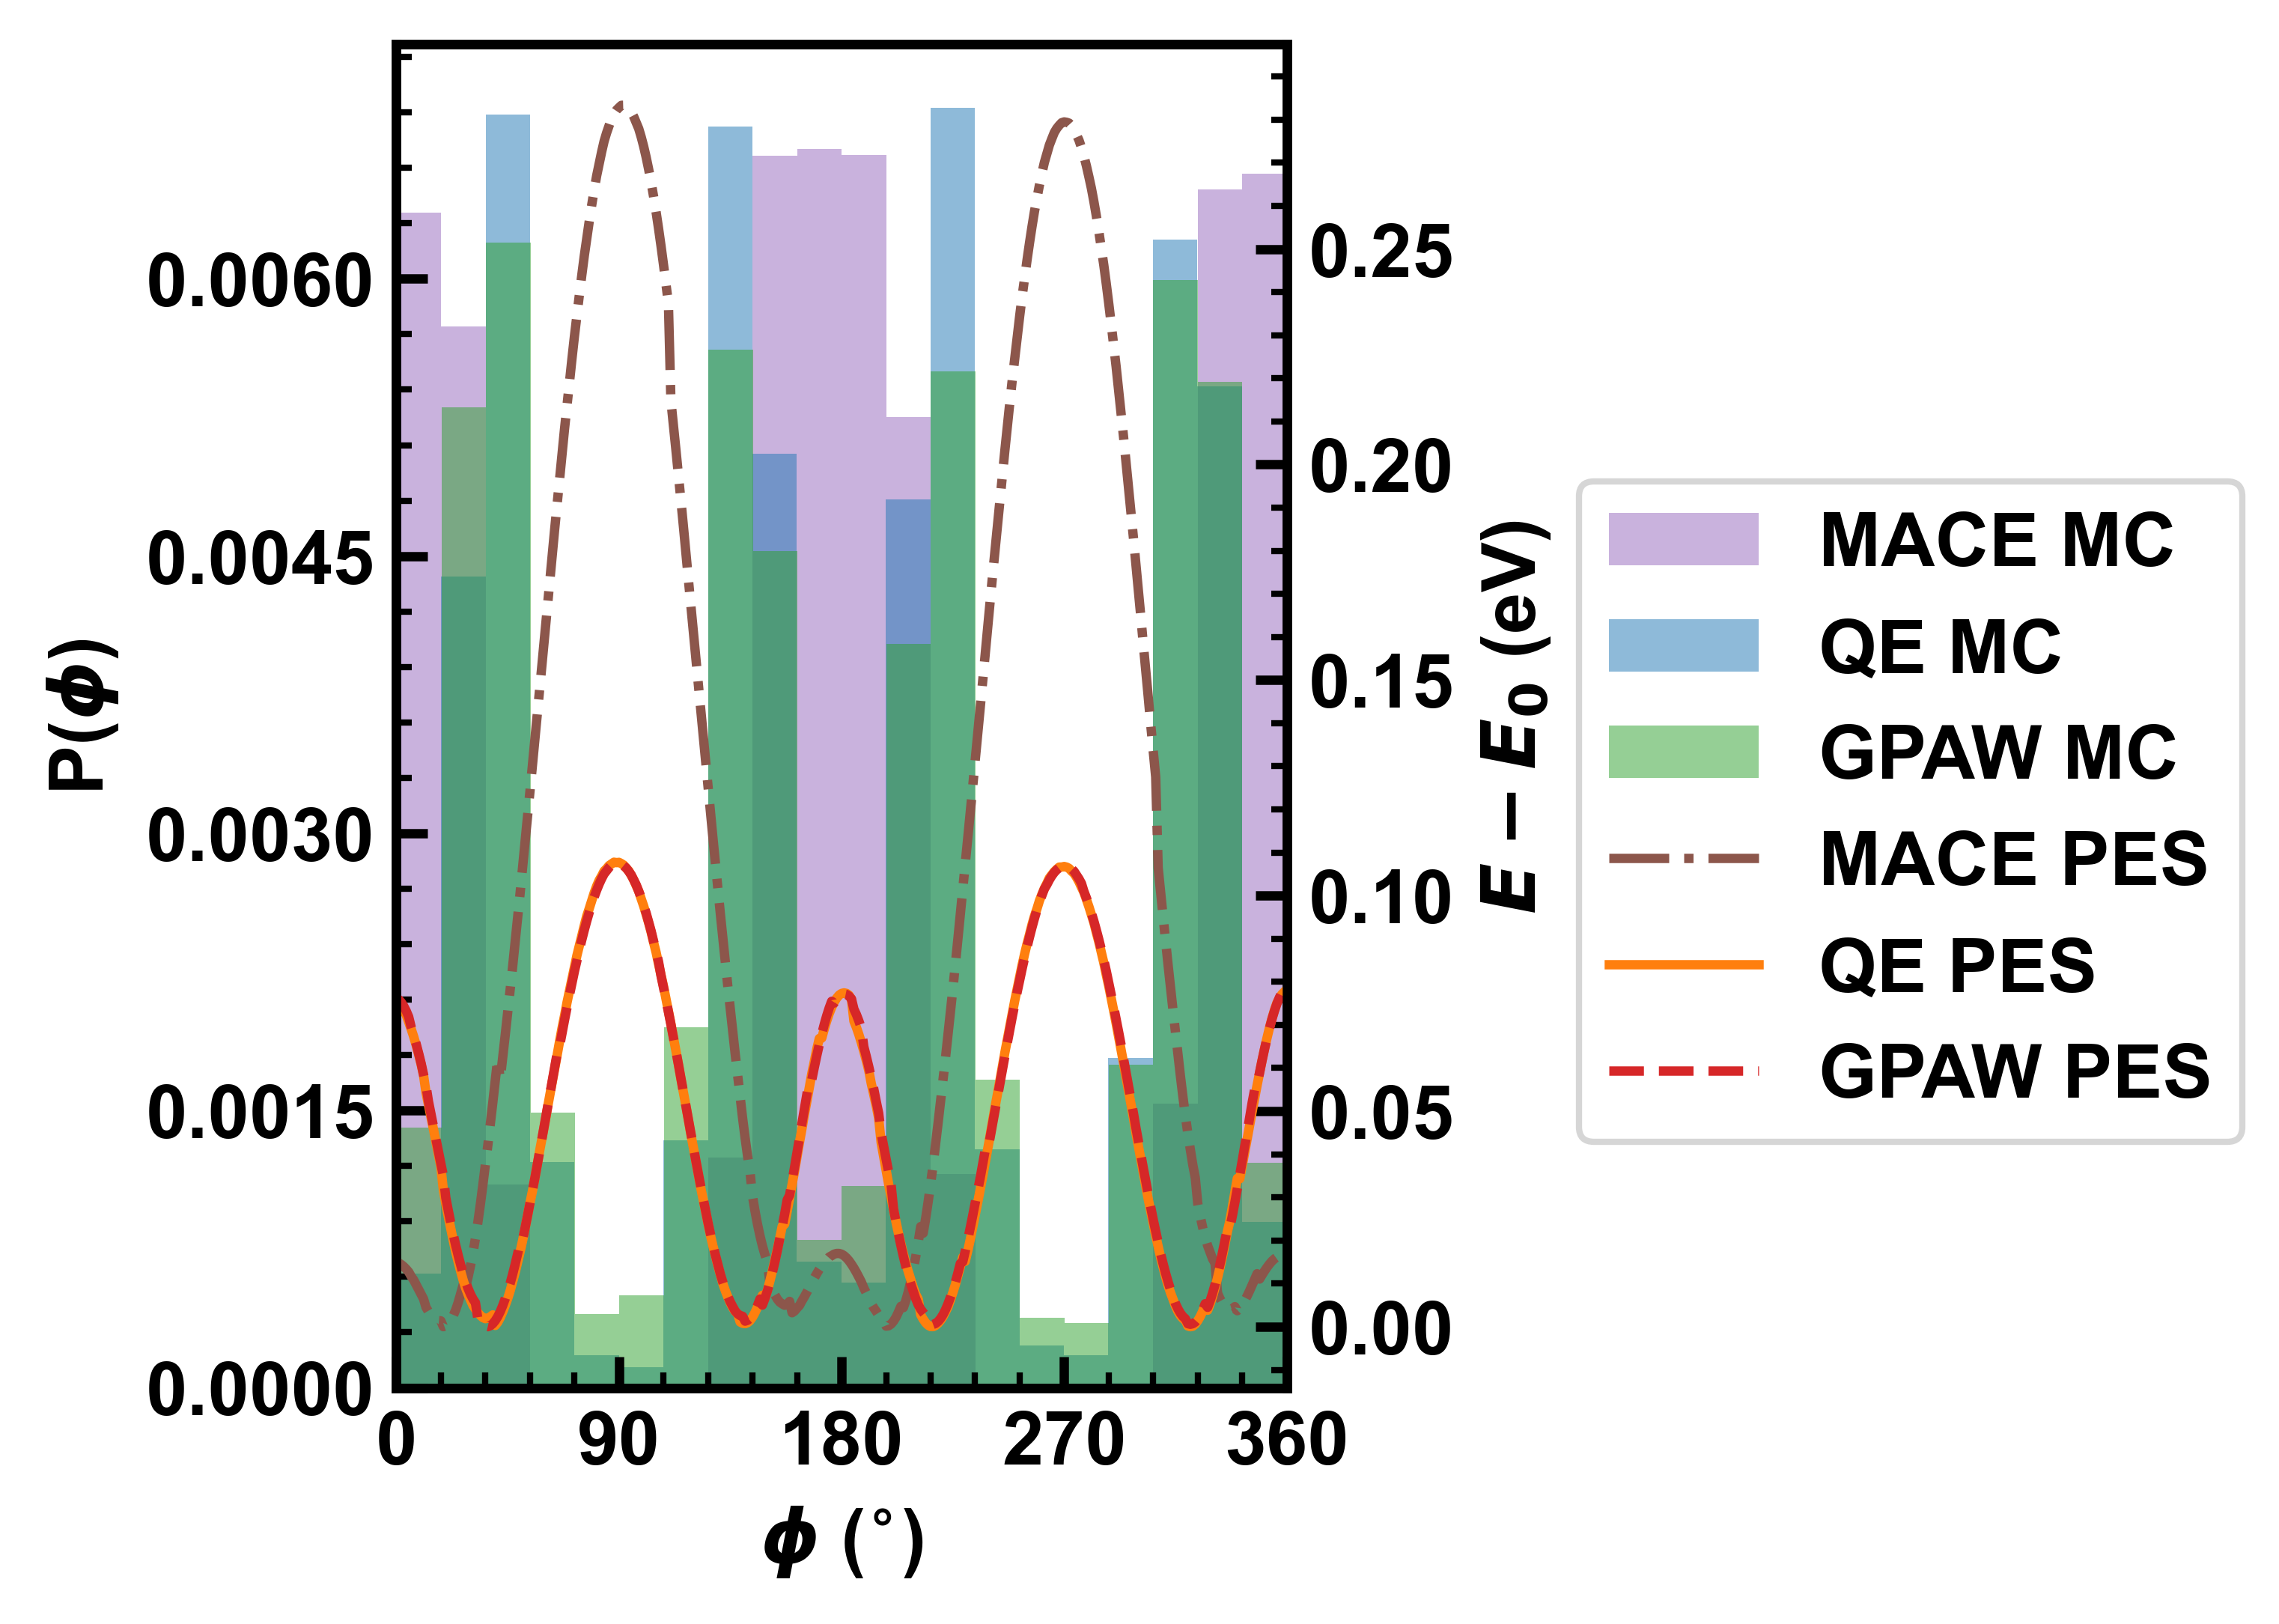

In [9]:
fig, axs = plt.subplots(
    nrows = 1, ncols = 1, 
    figsize=(5, 3.5), dpi=600, 
    sharex = False, sharey = False, 
    layout="constrained"
    )



ax2 = axs.twinx()



mc_qe_phi = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/biphenyl/qe/mc/analysis/phis.npy")
qe_hist, qe_bin_edges = np.histogram(mc_qe_phi, bins = 20, density=True)

mc_gpaw_phi = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/biphenyl/gpaw/mc/analysis/phis.npy")
gpaw_hist, gpaw_bin_edges = np.histogram(mc_gpaw_phi,  bins = 20, density=True)

mc_mace_phi = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/biphenyl/mace/mc/analysis/phis.npy")
mace_hist, mace_bin_edges = np.histogram(mc_mace_phi,  bins = 20, density=True)

scan_qe_phi = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/biphenyl/qe/scan/analysis/phis.npy")
scan_qe_energy = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/biphenyl/qe/scan/analysis/energies.npy")
scan_qe_energy -= np.min(scan_qe_energy)


scan_gpaw_phi = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/biphenyl/gpaw/scan/analysis/phis.npy")
scan_gpaw_energy = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/biphenyl/gpaw/scan/analysis/energies.npy")
scan_gpaw_energy -= np.min(scan_gpaw_energy)


scan_mace_phi = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/biphenyl/mace/scan/analysis/phis.npy")
scan_mace_energy = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/biphenyl/mace/scan/analysis/energies.npy")
scan_mace_energy -= np.min(scan_mace_energy)


axs.stairs(mace_hist, mace_bin_edges, fill = True, alpha = 0.5, label = "MACE MC", color = colors[4])
ax2.plot(scan_mace_phi , scan_mace_energy, linestyle = "dashdot", label = "MACE PES", color = colors[5])

axs.stairs(qe_hist, qe_bin_edges, fill = True, alpha = 0.5, label = "QE MC", color = colors[0])
ax2.plot(scan_qe_phi , scan_qe_energy, linestyle = "solid", label = "QE PES", color = colors[1])

axs.stairs(gpaw_hist, gpaw_bin_edges,  fill = True,  alpha = 0.5, label = "GPAW MC", color = colors[2])
ax2.plot(scan_gpaw_phi , scan_gpaw_energy, linestyle = "dashed", label = "GPAW PES", color = colors[3])




axs.set_xlabel(r'$\phi$ ($^{\circ}$)')

axs.set_ylabel(r'P($\phi$)')
ax2.set_ylabel(r'$E - E_0$ (eV)')

axs.set_xlim((0,360.0))

#axs.set_ylim((0,360.0))

fig.legend(loc = "outside center right")


set_ticks(axs, xlinear=True, ylinear=False, xmax=False, ymax=True, yticks = 5, xticks = 5)
save_figure(fig, prefix="biphenyl-histo")

In [13]:
(scan_mace_energy - scan_gpaw_energy )

array([-6.12780987e-02, -6.11081982e-02, -6.08266221e-02, -6.04095210e-02,
       -5.98626509e-02, -5.91768477e-02, -5.78047485e-02, -5.68093275e-02,
       -5.58745654e-02, -5.48057463e-02, -5.35963810e-02, -5.20279380e-02,
       -5.14372806e-02, -4.87414207e-02, -4.67087085e-02, -4.44409884e-02,
       -4.19142172e-02, -3.92919480e-02, -3.64771977e-02, -3.50326990e-02,
       -2.97437967e-02, -2.62445021e-02, -2.26220634e-02, -1.88744192e-02,
       -1.49856909e-02, -1.09386728e-02, -6.75698187e-03, -2.51609726e-03,
       -1.27976553e-03,  2.63566009e-03,  6.66012021e-03,  1.07893029e-02,
        1.50332080e-02,  2.27326586e-02,  2.76340019e-02,  3.25863764e-02,
        3.74966831e-02,  4.21295166e-02,  4.67645121e-02,  5.12690107e-02,
        5.56621809e-02,  5.99439183e-02,  5.38190062e-02,  5.75024773e-02,
        6.10592674e-02,  6.45442857e-02,  6.79076389e-02,  7.12847946e-02,
        7.46086064e-02,  7.78926142e-02,  8.09476223e-02,  8.61760552e-02,
        8.94192908e-02,  

# Water RDFs

/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/water/mace/rdf_md/rdf_H2O_H2O_[Or_Oo].csv
Relative Maxima
r [2.68333333 4.38333333 4.45      ]
rdf [3.77045814 1.53517693 1.52651668]
ni [ 1.52849095 10.85874866 11.69822978]

Relative Minima
r [3.25       4.41666667 5.48333333]
rdf [0.2385468  1.52362732 0.74781596]
ni [ 4.02343992 11.27493575 22.89543478]

/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/water/mace/rdf_md/rdf_H2O_H2O_[Or_Ho].csv
Relative Maxima
r [1.71666667 3.18333333 5.11666667]
rdf [2.00822334 1.71866416 1.11516112]
ni [ 0.80042361  5.75017124 36.63641279]

Relative Minima
r [2.45       4.11666667]
rdf [0.04158671 0.9569546 ]
ni [ 1.97032971 17.80526102]

/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/water/mace/rdf_md/rdf_H2O_H2O_[Hr_Ho].csv
Relative Maxima
r [1.38333333 2.25       3.78333333 5.65      ]
rdf [8.17220820e-06 1.85042620e+00 1.31416096e+00 1.01304442e+00]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


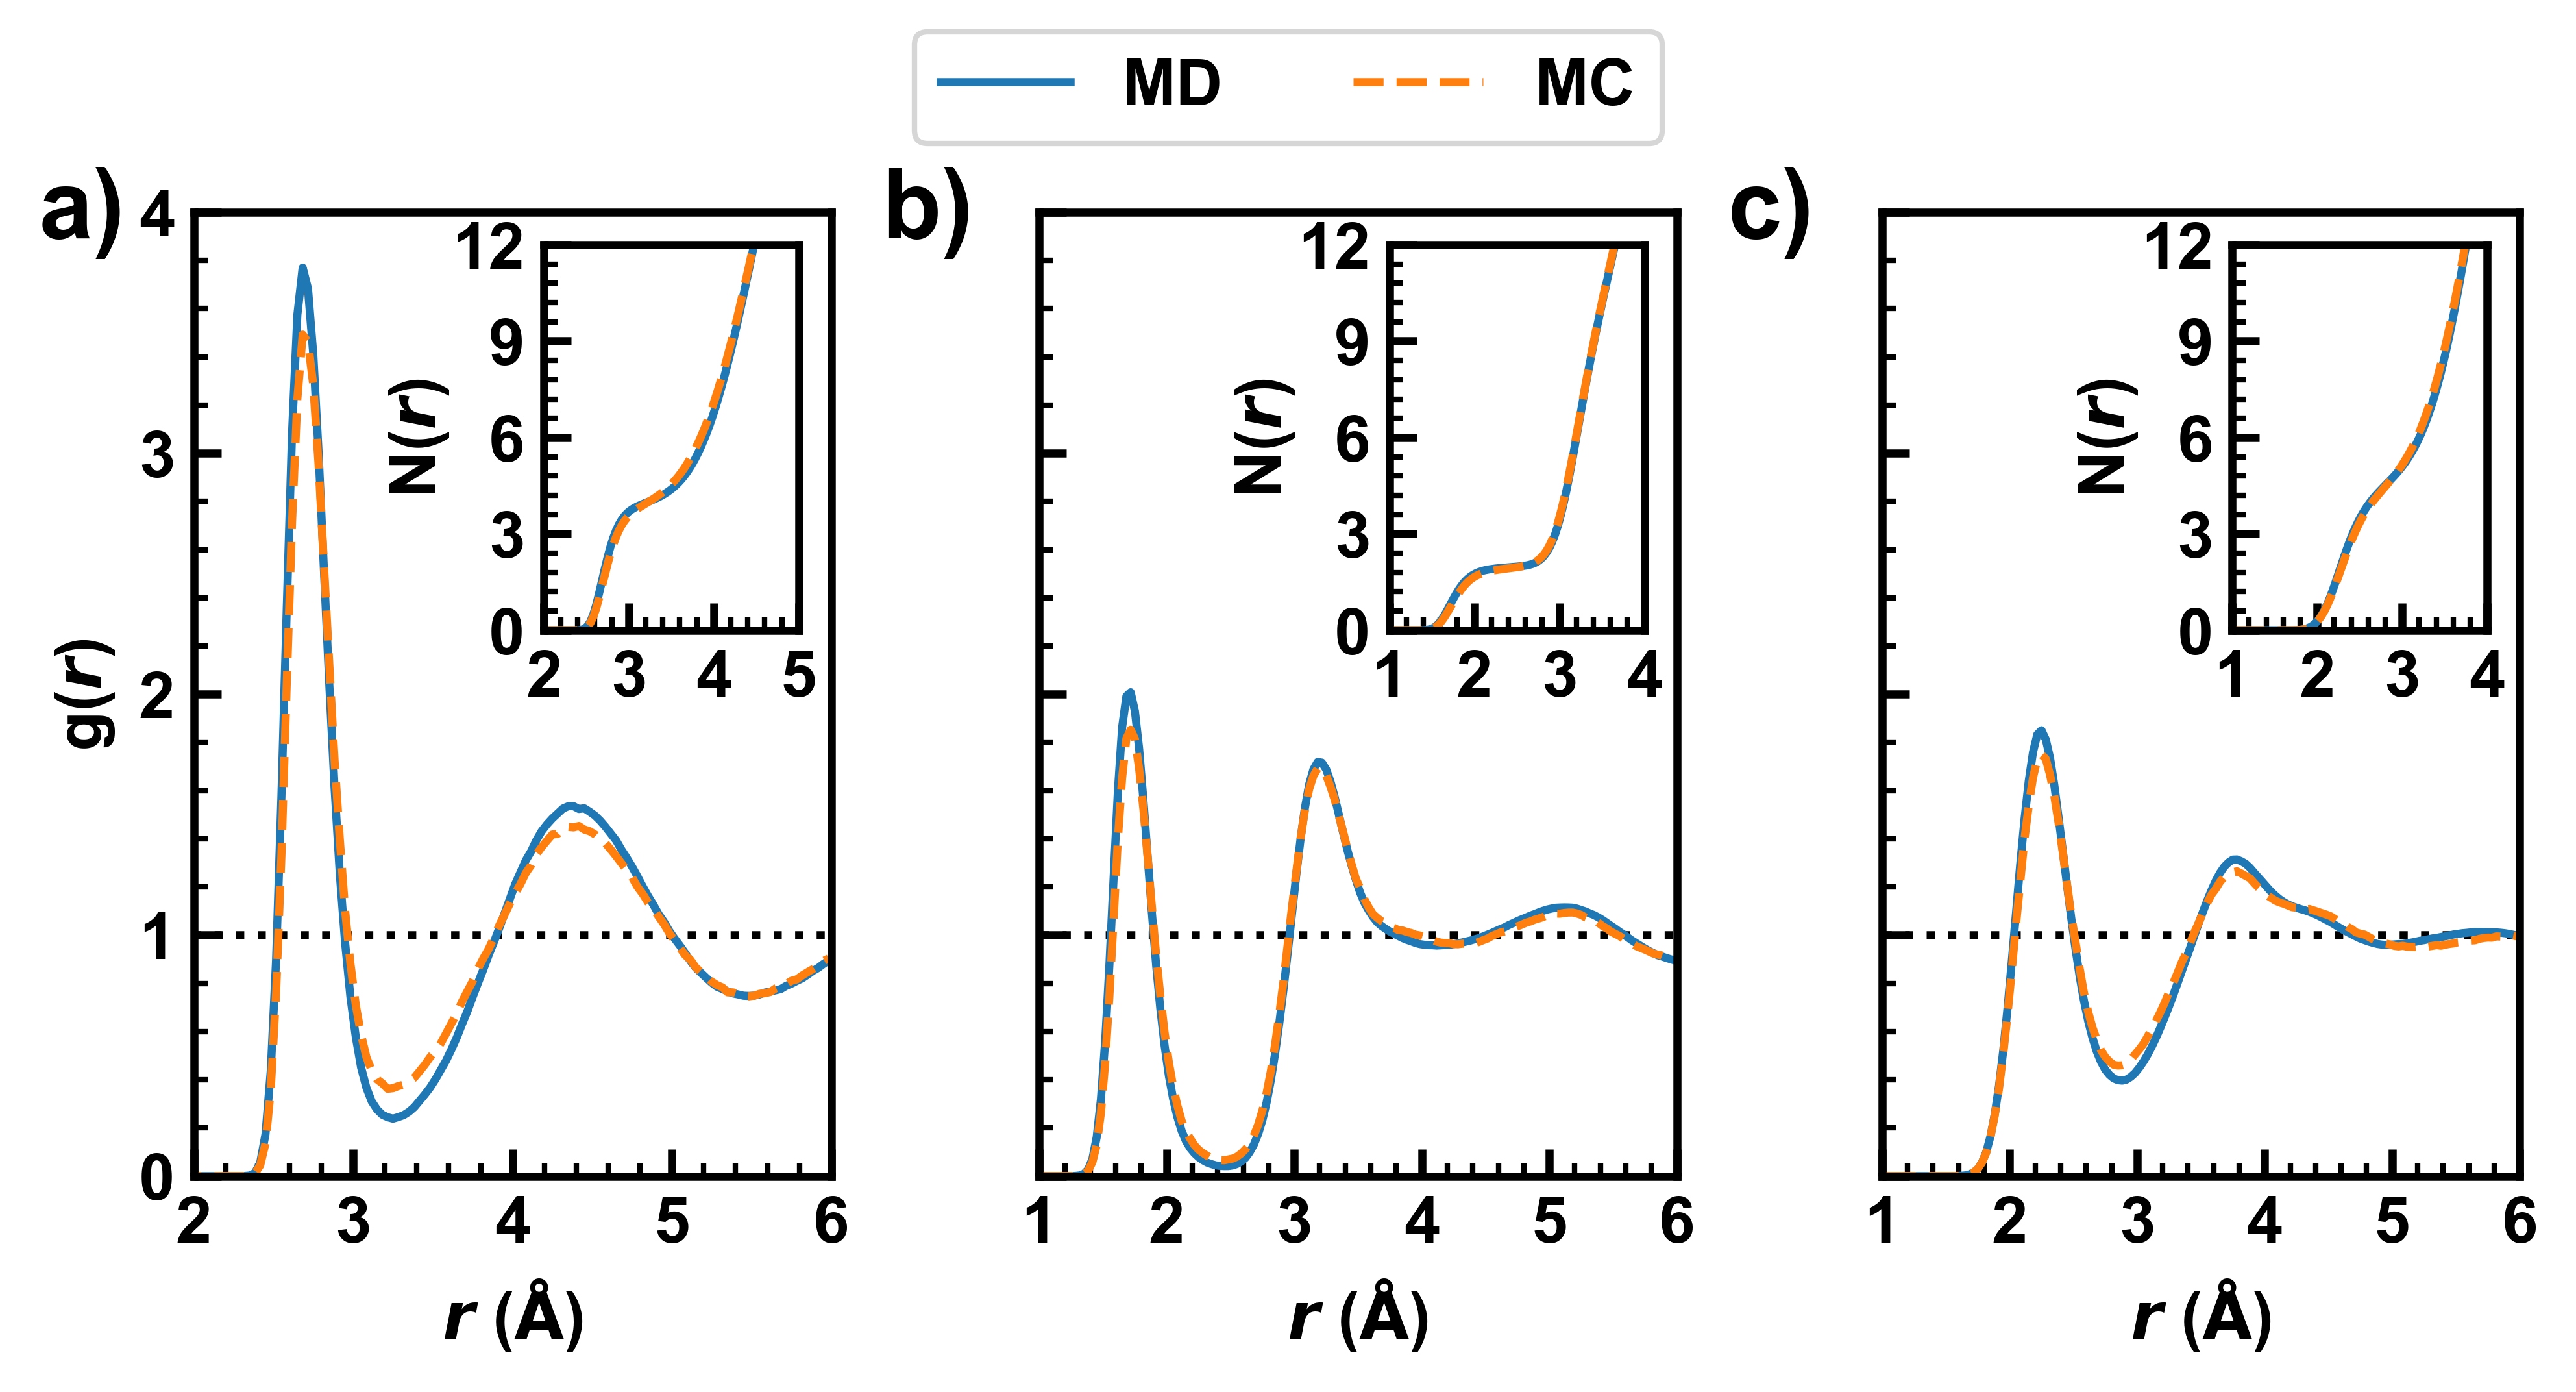

In [11]:
fig, axs = plt.subplot_mosaic(
    [['a)', "b)", "c)"]], 
    figsize=(6.5, 3.5), dpi=600, 
    sharex = False, sharey = True, 
    layout="constrained"
    )



def find_extrema_travis(filename):
    from scipy.signal import argrelextrema
    print(filename)

    arr = np.loadtxt(filename, skiprows=1, delimiter=";") 

    x = arr[:,0] * 0.01
    ni = arr[:,2]
    rdf = arr[:,1]

    print("Relative Maxima")
    max_indices = argrelextrema(rdf, np.greater)[0]
    print("r", x[max_indices])
    print("rdf", rdf[max_indices])
    print("ni", ni[max_indices])
    print()

    # for local minima
    min_indices = argrelextrema(rdf, np.less)[0]
    print("Relative Minima")
    print("r", x[min_indices])
    print("rdf", rdf[min_indices])
    print("ni", ni[min_indices])
    print()




prefix = "/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/nvt/water/mace"
travis_md_oo_rdf = np.loadtxt(f"{prefix}/rdf_md/rdf_H2O_H2O_[Or_Oo].csv", skiprows=1, delimiter=";")
find_extrema_travis(f"{prefix}/rdf_md/rdf_H2O_H2O_[Or_Oo].csv")


travis_md_oh_rdf = np.loadtxt(f"{prefix}/rdf_md/rdf_H2O_H2O_[Or_Ho].csv", skiprows=1, delimiter=";")
find_extrema_travis(f"{prefix}/rdf_md/rdf_H2O_H2O_[Or_Ho].csv")

travis_md_hh_rdf = np.loadtxt(f"{prefix}/rdf_md/rdf_H2O_H2O_[Hr_Ho].csv", skiprows=1, delimiter=";") 
find_extrema_travis(f"{prefix}/rdf_md/rdf_H2O_H2O_[Hr_Ho].csv")



# Travis uses pm for distance, convert to angstrom
travis_md_oo_rdf[:,0] *= 0.01
travis_md_oh_rdf[:,0] *= 0.01
travis_md_hh_rdf[:,0] *= 0.01


travis_mc_oo_rdf = np.loadtxt(f"{prefix}/rdf_mc/rdf_H2O_H2O_[Or_Oo].csv", skiprows=1, delimiter=";")
find_extrema_travis(f"{prefix}/rdf_mc/rdf_H2O_H2O_[Or_Oo].csv")


travis_mc_oh_rdf = np.loadtxt(f"{prefix}/rdf_mc/rdf_H2O_H2O_[Or_Ho].csv", skiprows=1, delimiter=";")
find_extrema_travis(f"{prefix}/rdf_mc/rdf_H2O_H2O_[Or_Ho].csv")


travis_mc_hh_rdf = np.loadtxt(f"{prefix}/rdf_mc/rdf_H2O_H2O_[Hr_Ho].csv", skiprows=1, delimiter=";") 
find_extrema_travis(f"{prefix}/rdf_mc/rdf_H2O_H2O_[Hr_Ho].csv")



# Travis uses pm for distance, convert to angstrom
travis_mc_oo_rdf[:,0] *= 0.01
travis_mc_oh_rdf[:,0] *= 0.01
travis_mc_hh_rdf[:,0] *= 0.01



axs['a)'].hlines(xmin=0, xmax=6, y=1.0, color="k", linestyles='dotted')
axs['b)'].hlines(xmin=0, xmax=6, y=1.0, color="k", linestyles='dotted')
axs['c)'].hlines(xmin=0, xmax=6, y=1.0, color="k", linestyles='dotted')

# O-O
axs['a)'].plot(travis_md_oo_rdf[:,0], travis_md_oo_rdf[:,1], label = "MD")
axs['a)'].plot(travis_mc_oo_rdf[:,0], travis_mc_oo_rdf[:,1], linestyle="dashed", label = "MC")
axins = inset_axes(axs['a)'], width="40%", height="40%")
axins.plot(travis_md_oo_rdf[:,0], travis_md_oo_rdf[:,2])
axins.plot(travis_mc_oo_rdf[:,0], travis_mc_oo_rdf[:,2], linestyle="dashed")
#axins.grid(True)
set_ticks(axins, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 3)
axins.set_xlim((2, 5))
axins.set_ylim((0, 12))
axins.set_ylabel(r"N($r$)", labelpad=0.25)


# O-H
axs['b)'].plot(travis_md_oh_rdf[:,0], travis_md_oh_rdf[:,1])
axs['b)'].plot(travis_mc_oh_rdf[:,0], travis_mc_oh_rdf[:,1], linestyle="dashed")
axins = inset_axes(axs['b)'], width="40%", height="40%")
axins.plot(travis_md_oh_rdf[:,0], travis_md_oh_rdf[:,2])
axins.plot(travis_mc_oh_rdf[:,0], travis_mc_oh_rdf[:,2], linestyle="dashed")
#axins.grid(True)
set_ticks(axins, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 3)
axins.set_xlim((1, 4))
axins.set_ylim((0, 12))
axins.set_ylabel(r"N($r$)", labelpad=0.25)


# H-H
axs['c)'].plot(travis_md_hh_rdf[:,0], travis_md_hh_rdf[:,1])
axs['c)'].plot(travis_mc_hh_rdf[:,0], travis_mc_hh_rdf[:,1], linestyle="dashed")
axins = inset_axes(axs['c)'], width="40%", height="40%")
axins.plot(travis_md_hh_rdf[:,0], travis_md_hh_rdf[:,2])
axins.plot(travis_mc_hh_rdf[:,0], travis_mc_hh_rdf[:,2], linestyle="dashed")
#axins.grid(True)
set_ticks(axins, xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 3)
axins.set_xlim((1, 4))
axins.set_ylim((0, 12))
axins.set_ylabel(r"N($r$)", labelpad=0.25)


#axs['b)'].plot(travis_md_oo_rdf[:,0], travis_md_oo_rdf[:,2], marker = "s", markevery=9)
#axs['b)'].plot(travis_md_oh_rdf[:,0], travis_md_oh_rdf[:,2], marker = "D", markevery=9)
#axs['b)'].plot(travis_md_hh_rdf[:,0], travis_md_hh_rdf[:,2], marker = "o", markevery=9)

#axs['b)'].plot(travis_mc_oo_rdf[:,0], travis_mc_oo_rdf[:,2], linestyle="dashed", marker = "p", markevery=9)
#axs['b)'].plot(travis_mc_oh_rdf[:,0], travis_mc_oh_rdf[:,2], linestyle="dashed", marker = "^", markevery=9)
#axs['b)'].plot(travis_mc_hh_rdf[:,0], travis_mc_hh_rdf[:,2], linestyle="dashed", marker = "^", markevery=9)



print(f"H-H $R^2$ = {r2_score(travis_mc_hh_rdf[:,1], travis_md_hh_rdf[:,1])}")
print(f"O-H $R^2$ = {r2_score(travis_mc_oh_rdf[:,1], travis_md_oh_rdf[:,1])}")
print(f"O-O $R^2$ = {r2_score(travis_mc_oo_rdf[:,1], travis_md_oo_rdf[:,1])}")


axs['a)'].set_xlim((2,6))
axs['b)'].set_xlim((1,6))
axs['c)'].set_xlim((1,6))

axs['b)'].set_ylim((0,4))

axs['a)'].set_xlabel("$r$ ($\mathrm{\AA}$)")
axs['b)'].set_xlabel("$r$ ($\mathrm{\AA}$)")
axs['c)'].set_xlabel("$r$ ($\mathrm{\AA}$)")
axs['a)'].set_ylabel("g($r$)")
#axs['b)'].set_ylabel("N($r$)")

set_ticks(axs['a)'], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 4)
set_ticks(axs['b)'], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 5)
set_ticks(axs['c)'], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 5)


fig.legend(loc="outside upper center", ncols = 2)


label_mosaic_subplot(axs, outside = True, size = 18)

save_figure(fig, prefix="water-rdf")





# Water NPT

MD: 912.9352863377997 +/- 20.064511691409106
MC (HMC): 921.7284382028591 +/- 18.26729747516867
MC (HMC+TRN+ROT): 923.2746979187654 +/- 21.34328464282721


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


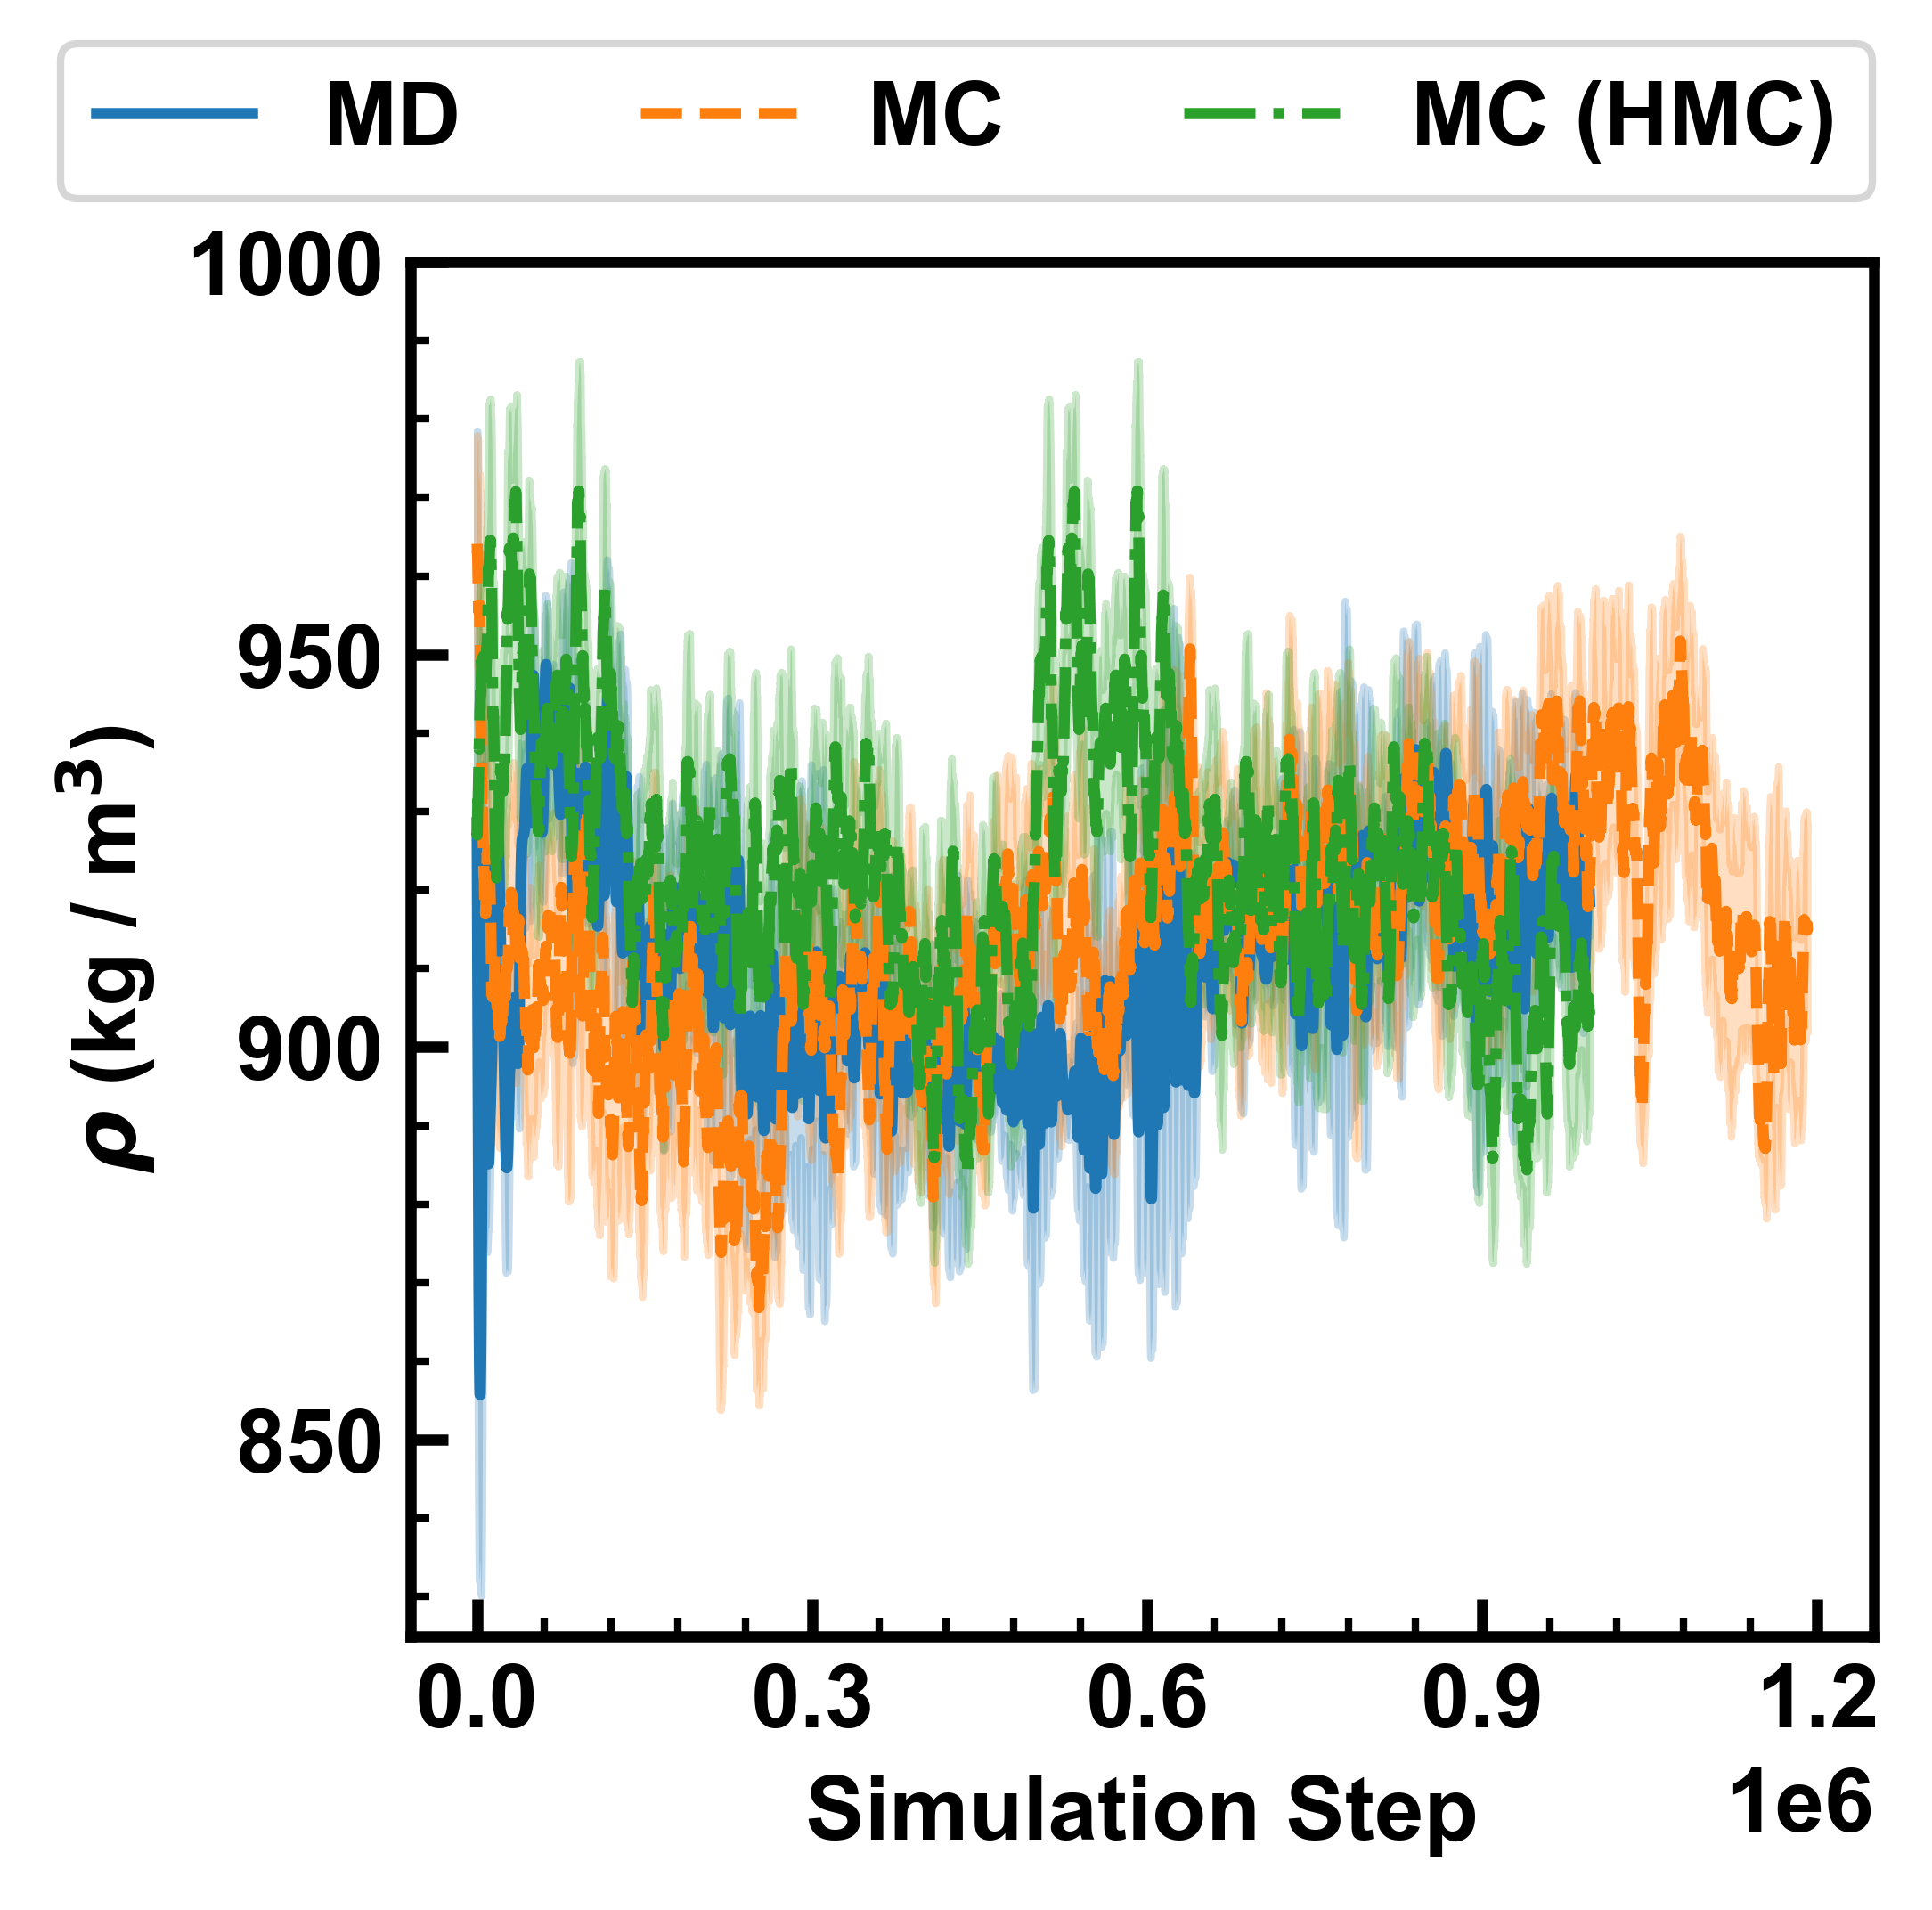

In [ ]:

fig, axs = plt.subplot_mosaic(
    [['a)']], 
    figsize=(3.5, 3.5), dpi=600, 
    sharex = False, sharey = True, 
    layout="constrained"
    )


steps_per_frame = 4
md_density_0 = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/npt/water/md/density/density.npy")
md_density_1 = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/npt/water/md/density_restart-1/density.npy")
md_density = np.hstack((md_density_0, md_density_1))


hmc_density_0 = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/npt/water/hmc/density/density.npy")
hmc_density_1 = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/npt/water/hmc/density_restart-1/density.npy")[-125000:]
hmc_density = np.hstack((hmc_density_0, hmc_density_1)) 

print(len(md_density))
print(len(hmc_density))

trn_rot_hmc_density_0  = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/npt/water/trn-rot-hmc/density/density.npy") 
trn_rot_hmc_density_1  = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/npt/water/trn-rot-hmc/density/density.npy") 
trn_rot_hmc_density  = np.hstack((trn_rot_hmc_density_0 , trn_rot_hmc_density_1 )) 



def plot_moving(ax, array, label, linestyle, color, window = 1000, logfreq = 4):
    avg = moving_average(array, window, mode = "valid")
    std = moving_std_manual(array, window)
    x = np.arange(len(avg))
    ax.plot(x * logfreq, avg, label = label, linestyle = linestyle, color = color)
    ax.fill_between(x * logfreq, avg - std, avg + std, color=color, alpha=0.25)





start = len(md_density)//2
print("MD:", np.mean(md_density[start:]), "+/-", np.std(md_density[start:]))
print("MC (HMC):", np.mean(hmc_density[start:]), "+/-", np.std(hmc_density[start:]))
print("MC (HMC+TRN+ROT):", np.mean(trn_rot_hmc_density[start:]), "+/-", np.std(trn_rot_hmc_density[start:]))

plot_moving(axs["a)"], md_density, "MD", "solid", colors[0], window = 1000)
plot_moving(axs["a)"], hmc_density, "MC", "dashed", colors[1], window = 1000)
plot_moving(axs["a)"], trn_rot_hmc_density, "MC (HMC)", "dashdot", colors[2], window = 1000)

axs["a)"].set_ylabel(r"$\rho$ (kg / m$^3$)")
axs["a)"].set_xlabel("Simulation Step")

axs["a)"].set_ylim((825, 1000))

fig.legend(loc="outside upper center", ncols = 3, labelspacing=0.4, handlelength=1.75)
set_ticks(axs['a)'], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 5)

save_figure(fig, prefix="water-npt")




In [5]:
x = np.arange(5)
y = np.arange(6)
np.hstack((x,y))

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5])

# TraPPE Methane NPT - NVT

MoSDeF-Cassandra 15.029705218710504 +/- 2.3293128475452494
ASE-MC (dV) 15.127370965849193 +/- 2.1049111953150303
ASE-MC (dlnV) 14.5035927119058 +/- 1.9512474498429273
/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/npt/trappe_methane/cassandra/rdf/rdf_C_C_[C1r_C1o].csv
Relative Maxima
r [ 4.15333333  7.51333333  8.07333333  8.26        8.82        9.28666667
  9.94       10.31333333 10.68666667 11.15333333 11.34       11.62
 11.80666667 11.99333333 12.36666667 12.55333333 12.74       12.92666667
 13.48666667 13.86      ]
rdf [2.65637663 1.07358152 1.05531478 1.05263933 1.03365556 1.02236239
 1.01095373 1.00551315 0.99839513 0.99215246 0.99245497 0.99111131
 0.98986074 0.99019602 0.98857747 0.98781277 0.98751601 0.9871704
 0.98635259 0.98137504]
ni [0.12138806 1.22694302 1.47964224 1.57120373 1.86766791 2.1420854
 2.56968551 2.83783862 3.12471584 3.5113603  3.67482158 3.93018036
 4.10698836 4.28956265 4.67129195 4.87078608 5.07646038 5.28801668
 5.95820918 6

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


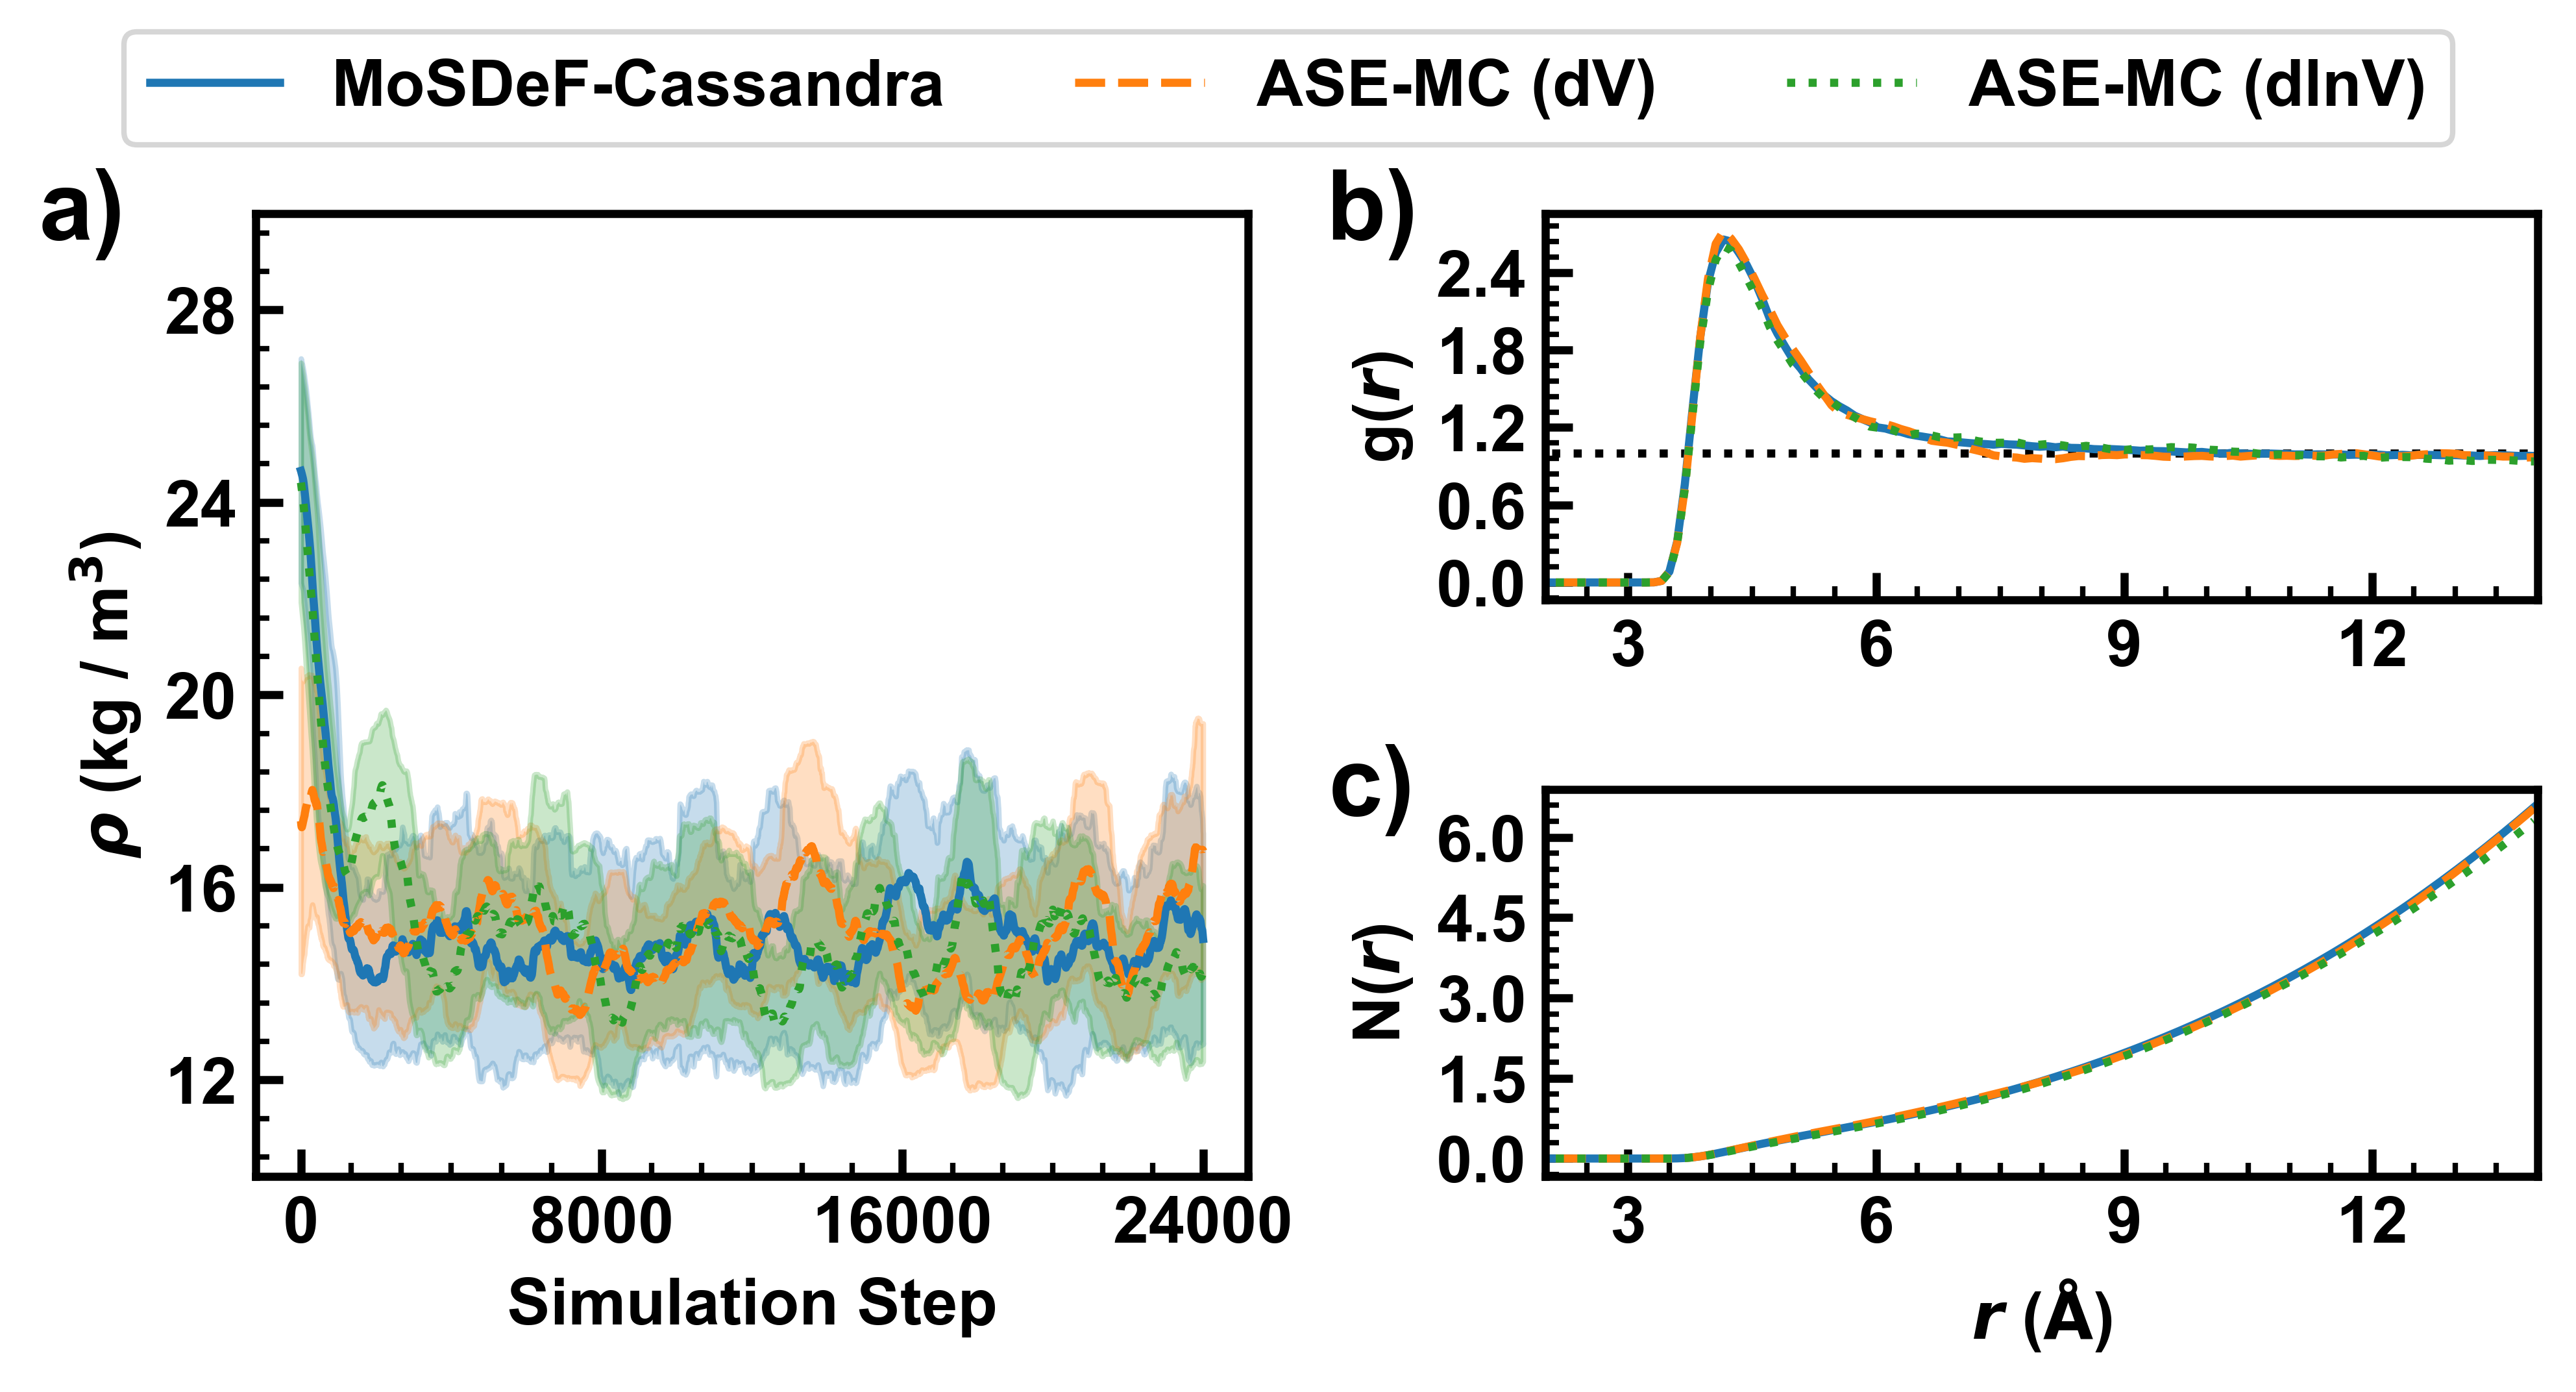

In [13]:
fig, axs = plt.subplot_mosaic(
    [['a)', "b)"], ["a)", "c)"]], 
    figsize=(6.5, 3.5), dpi=600, 
    sharex = False, sharey = False, 
    layout="constrained"
    )



def find_extrema_travis(filename):
    from scipy.signal import argrelextrema
    print(filename)

    arr = np.loadtxt(filename, skiprows=1, delimiter=";") 

    x = arr[:,0] * 0.01
    ni = arr[:,2]
    rdf = arr[:,1]

    print("Relative Maxima")
    max_indices = argrelextrema(rdf, np.greater)[0]
    print("r", x[max_indices])
    print("rdf", rdf[max_indices])
    print("ni", ni[max_indices])
    print()

    # for local minima
    min_indices = argrelextrema(rdf, np.less)[0]
    print("Relative Minima")
    print("r", x[min_indices])
    print("rdf", rdf[min_indices])
    print("ni", ni[min_indices])
    print()



prefix = "/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/npt/trappe_methane"
ase_density_lnV = np.load(f"{prefix}/equal-thermal-mech/asemc-lnV/density.npy")
ase_density = np.load(f"{prefix}/equal-thermal-mech/asemc-V/density.npy")
cassandra_density = np.load(f"{prefix}/cassandra/equil.out.prp.Mass_Density.npy")


def plot_moving(ax, array, label, linestyle, color, window = 1000):
    avg = moving_average(array, window, mode = "vaid")
    #std = moving_std(array, window)
    std =  moving_std_manual(array, window)
    ax.plot(avg, label = label, linestyle = linestyle, color = color)
    ax.fill_between(np.arange(len(avg)), avg - std, avg + std, color=color, alpha=0.25)


plot_moving(axs["a)"], cassandra_density, "MoSDeF-Cassandra", "solid", colors[0], window = 1000)
plot_moving(axs["a)"], ase_density, "ASE-MC (dV)", "dashed", colors[1], window = 1000)
plot_moving(axs["a)"], ase_density_lnV, "ASE-MC (dlnV)", "dotted", colors[2], window = 1000)


def print_mean_and_std(label, data):
    nframes = len(data)
    mean = np.mean(data[nframes//2:])
    std = np.std(data[nframes//2:]) 
    print(label , mean, "+/-", std)

print_mean_and_std("MoSDeF-Cassandra",cassandra_density )
print_mean_and_std("ASE-MC (dV)", ase_density )
print_mean_and_std("ASE-MC (dlnV)", ase_density_lnV)

travis_cassandra_rdf = np.loadtxt(f"{prefix}/cassandra/rdf/rdf_C_C_[C1r_C1o].csv", skiprows=1, delimiter=";")
find_extrema_travis(f"{prefix}/cassandra/rdf/rdf_C_C_[C1r_C1o].csv")

travis_ase_rdf = np.loadtxt(f"{prefix}/equal-thermal-mech/asemc-V/rdf/rdf_C_C_[C1r_C1o].csv", skiprows=1, delimiter=";")
find_extrema_travis(f"{prefix}/equal-thermal-mech/asemc-V/rdf/rdf_C_C_[C1r_C1o].csv")

travis_aselnV_rdf = np.loadtxt(f"{prefix}/equal-thermal-mech/asemc-lnV/rdf/rdf_C_C_[C1r_C1o].csv", skiprows=1, delimiter=";") 
find_extrema_travis(f"{prefix}/equal-thermal-mech/asemc-lnV/rdf/rdf_C_C_[C1r_C1o].csv")



# Travis uses pm for distance, convert to angstrom
travis_cassandra_rdf[:,0] *= 0.01
travis_ase_rdf[:,0] *= 0.01
travis_aselnV_rdf[:,0] *= 0.01

axs['b)'].hlines(xmin=0, xmax=14, y=1.0, color="k", linestyles='dotted')

set_ticks(axs['b)'], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)
axs['b)'].set_xlim((2, 14))
axs['c)'].set_xlim((2, 14))

axs['b)'].plot(travis_cassandra_rdf[:,0], travis_cassandra_rdf[:,1], linestyle="solid")
axs['b)'].plot(travis_ase_rdf[:,0],travis_ase_rdf[:,1], linestyle="dashed")
axs['b)'].plot(travis_aselnV_rdf[:,0], travis_aselnV_rdf[:,1], linestyle="dotted")


axs['c)'].plot(travis_cassandra_rdf[:,0], travis_cassandra_rdf[:,2], linestyle="solid")
axs['c)'].plot(travis_ase_rdf[:,0],travis_ase_rdf[:,2], linestyle="dashed")
axs['c)'].plot(travis_aselnV_rdf[:,0], travis_aselnV_rdf[:,2], linestyle="dotted")
axs["c)"].grid(False)

for key, value in axs.items():
    set_ticks(axs[key], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 5, xticks = 4)
    axs[key].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(6))
    axs[key].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))

axs["b)"].set_ylabel(r"g($r$)")
axs["c)"].set_ylabel(r"N($r$)")
axs["c)"].set_xlabel(r"$r$ ($\mathrm{\AA}$)")


axs["a)"].set_ylim((10,30))

fig.legend(loc="outside upper center", ncols = 3)

label_mosaic_subplot(axs, outside = True, size = 18)

axs["a)"].set_ylabel(r"$\rho$ (kg / m$^3$)")
axs["a)"].set_xlabel("Simulation Step")

save_figure(fig, prefix="methane-workflow-equal-likelyhood")

# LJ Argon Validation for Cavity Bias GCMC

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


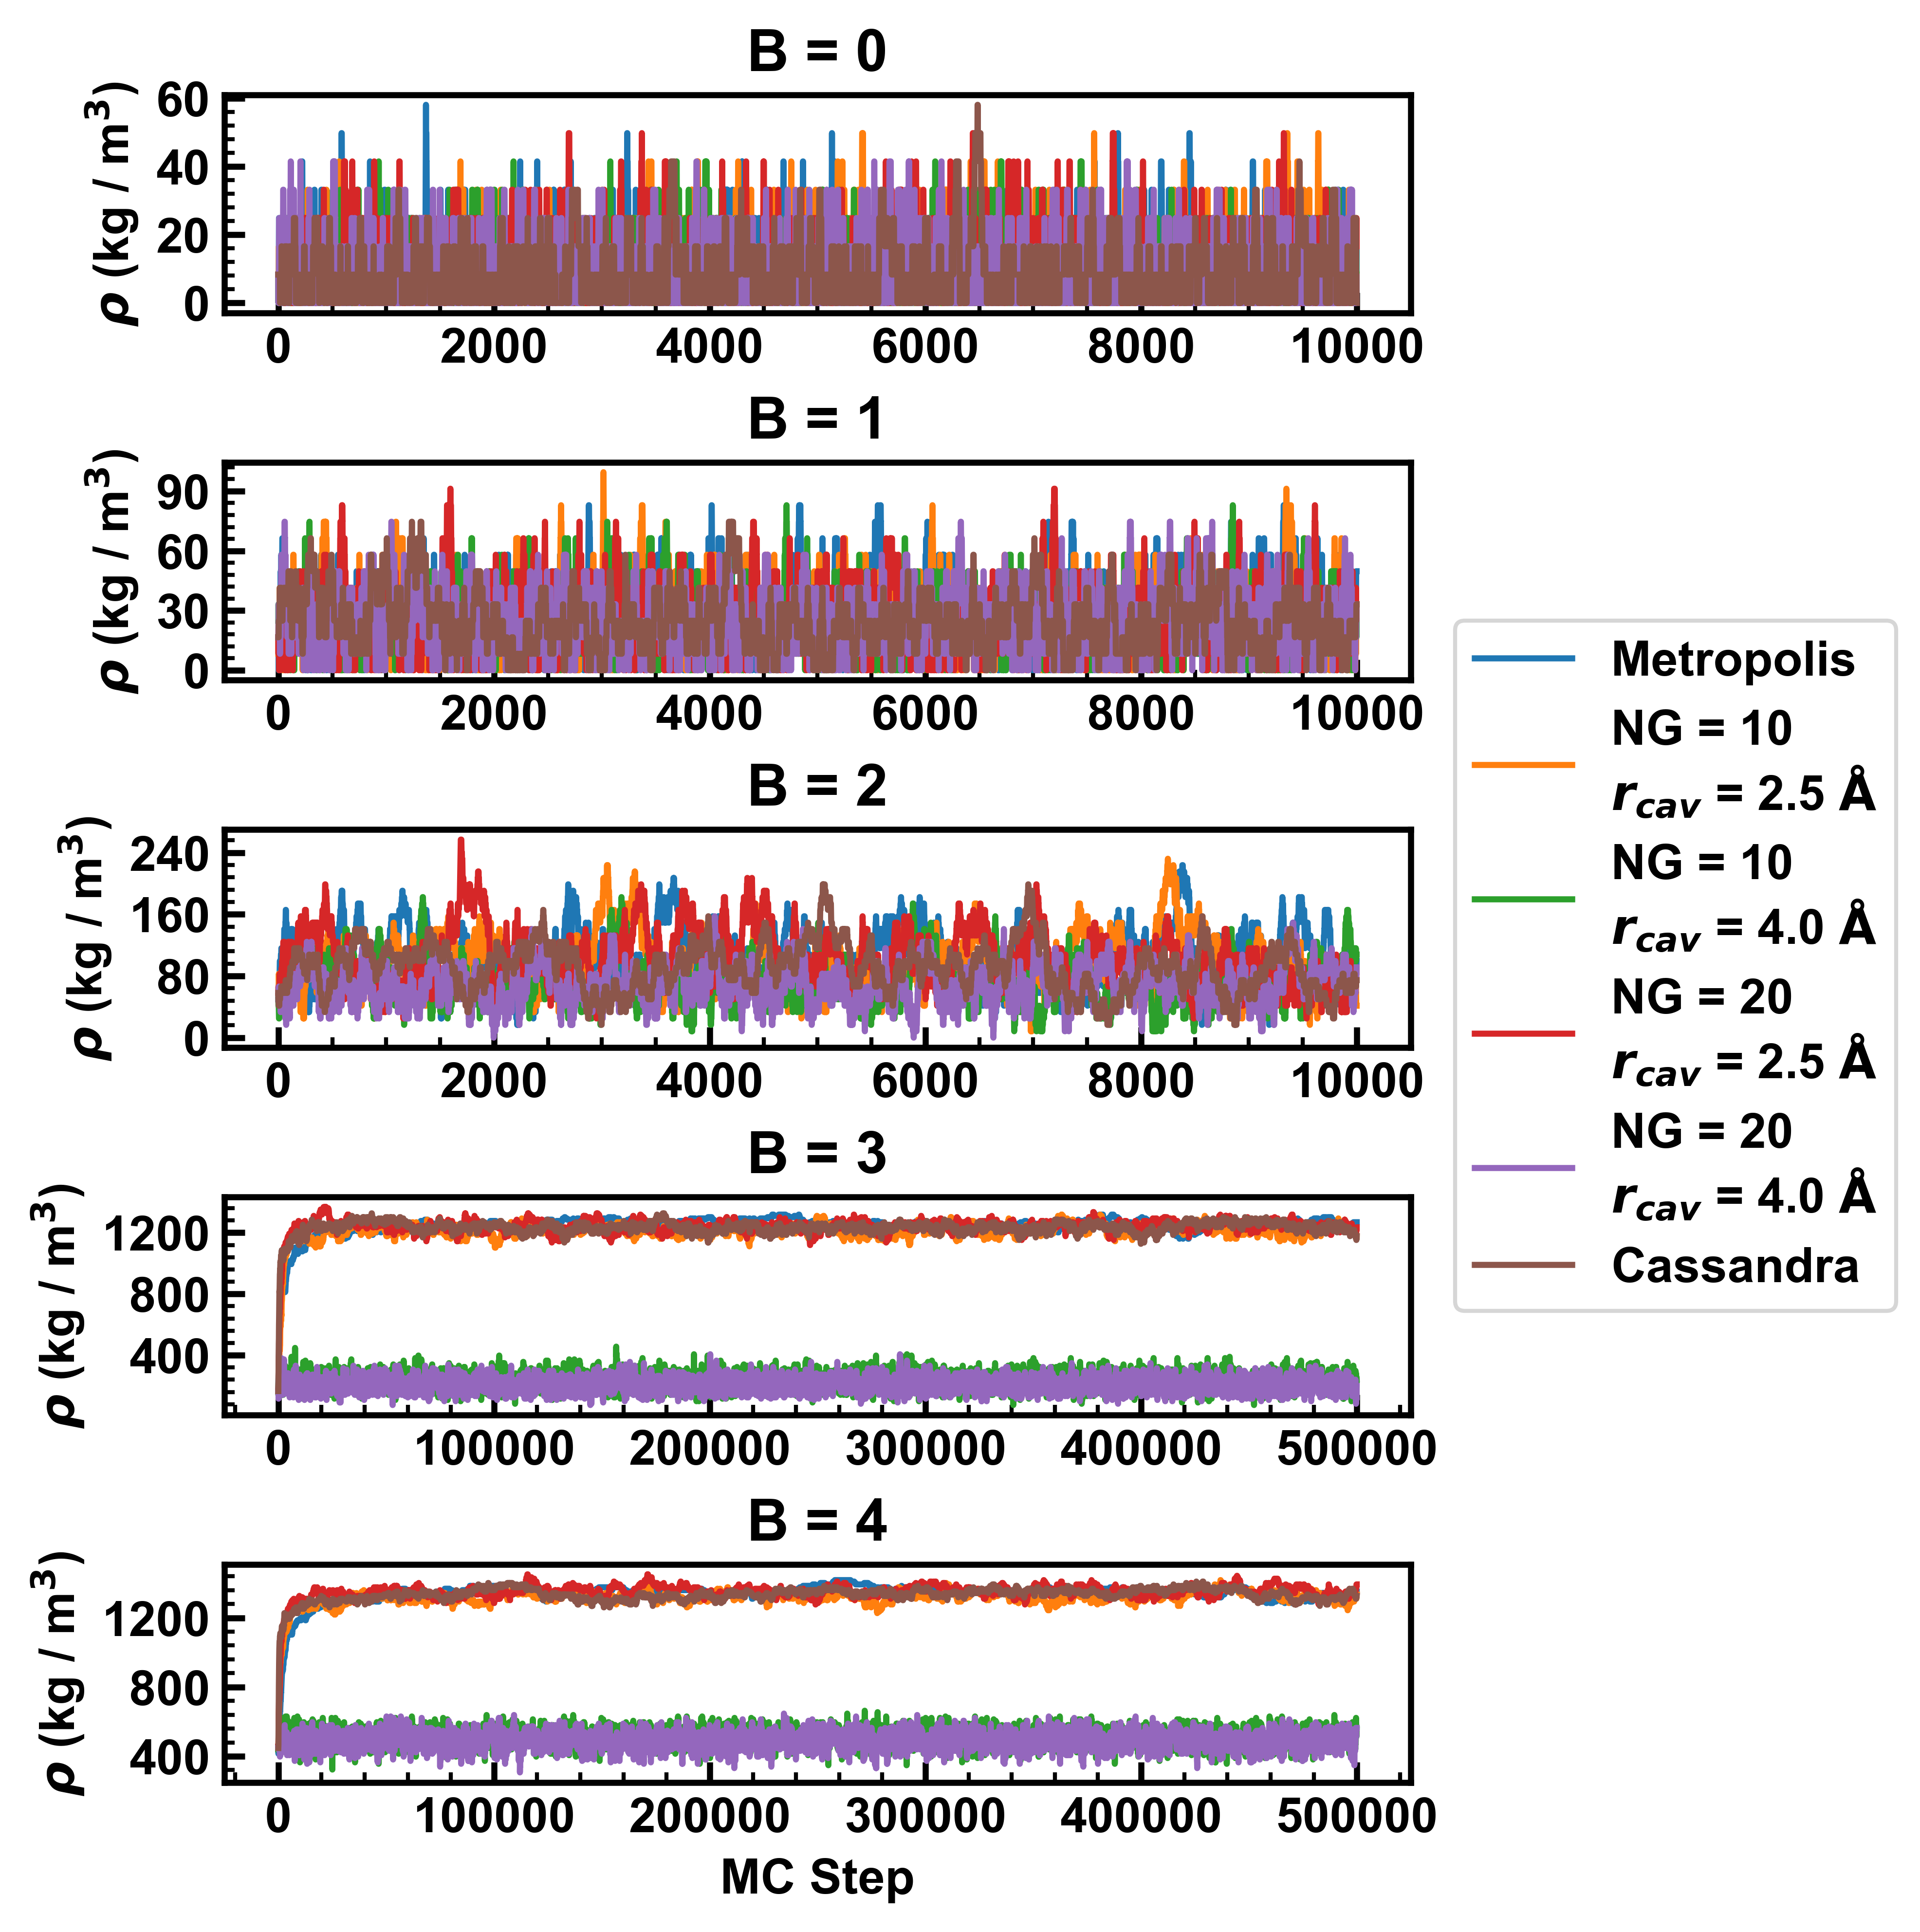

In [83]:
fig, axs = plt.subplot_mosaic(
    [['B = 0'],['B = 1'], ['B = 2'], ['B = 3'], ['B = 4']], 
    figsize=(6.5, 6.5), dpi=600, 
    sharex =False, sharey = False, 
    layout="constrained"
    )

prefix = "/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/gcmc/argon"



ase_densities = {
    "metropolis": {},
    "gres_10_rcav_2.5": {},
    "gres_10_rcav_4": {}, 
    "gres_20_rcav_2.5": {}, 
    "gres_20_rcav_4": {},  
}


cassandra_densities = {
    "metropolis": {},
    "bias": {},
}


Bs = ["0.0", "1.0", "2.0", "3.0", "4.0"]

for B in Bs:
    ase_densities["metropolis"][B]= np.load(f"{prefix}/classical/asemc/metropolis/{B}/density.npy")
    ase_densities["gres_10_rcav_2.5"][B]= np.load(f"{prefix}/classical/asemc/bias/gres_10_rcav_2.5/{B}/density.npy")
    ase_densities["gres_10_rcav_4"][B]= np.load(f"{prefix}/classical/asemc/bias/gres_10_rcav_4/{B}/density.npy")
    ase_densities["gres_20_rcav_2.5"][B]= np.load(f"{prefix}/classical/asemc/bias/gres_20_rcav_2.5/{B}/density.npy")
    ase_densities["gres_20_rcav_4"][B]= np.load(f"{prefix}/classical/asemc/bias/gres_20_rcav_4/{B}/density.npy")

    cassandra_densities["metropolis"][B]= np.load(f"{prefix}/classical/cassandra/metropolis/{B}/equil.out.prp.Mass_Density.npy")
    cassandra_densities["bias"][B]= np.load(f"{prefix}/classical/cassandra/bias/{B}/equil.out.prp.Mass_Density.npy")



labels = ["Metropolis",
          "NG = 10\n$r_{cav}$ = 2.5 $\mathrm{\AA}$",
          "NG = 10\n$r_{cav}$ = 4.0 $\mathrm{\AA}$", 
          "NG = 20\n$r_{cav}$ = 2.5 $\mathrm{\AA}$",
          "NG = 20\n$r_{cav}$ = 4.0 $\mathrm{\AA}$",
          "Cassandra",
          "Cassandra (Met.)"    
          ]


axs["B = 0"].plot(ase_densities["metropolis"]["0.0"], label = labels[0])
axs["B = 0"].plot(ase_densities["gres_10_rcav_2.5"]["0.0"], label = labels[1])
axs["B = 0"].plot(ase_densities["gres_10_rcav_4"]["0.0"], label = labels[2])
axs["B = 0"].plot(ase_densities["gres_20_rcav_2.5"]["0.0"], label = labels[3])
axs["B = 0"].plot(ase_densities["gres_20_rcav_4"]["0.0"], label = labels[4])
axs["B = 0"].plot(cassandra_densities["bias"]["0.0"], label = labels[5])
#axs["B = 0"].plot(cassandra_densities["metropolis"]["0.0"], label = labels[6])

axs["B = 1"].plot(ase_densities["metropolis"]["1.0"])
axs["B = 1"].plot(ase_densities["gres_10_rcav_2.5"]["1.0"])
axs["B = 1"].plot(ase_densities["gres_10_rcav_4"]["1.0"])
axs["B = 1"].plot(ase_densities["gres_20_rcav_2.5"]["1.0"])
axs["B = 1"].plot(ase_densities["gres_20_rcav_4"]["1.0"])
axs["B = 1"].plot(cassandra_densities["bias"]["1.0"])
#axs["B = 1"].plot(cassandra_densities["metropolis"]["1.0"])

axs["B = 2"].plot(ase_densities["metropolis"]["2.0"])
axs["B = 2"].plot(ase_densities["gres_10_rcav_2.5"]["2.0"])
axs["B = 2"].plot(ase_densities["gres_10_rcav_4"]["2.0"])
axs["B = 2"].plot(ase_densities["gres_20_rcav_2.5"]["2.0"])
axs["B = 2"].plot(ase_densities["gres_20_rcav_4"]["2.0"])
axs["B = 2"].plot(cassandra_densities["bias"]["2.0"])
#axs["B = 2"].plot(cassandra_densities["metropolis"]["2.0"])


axs["B = 3"].plot(np.arange(0, len(ase_densities["metropolis"]["3.0"]))*50, ase_densities["metropolis"]["3.0"])
axs["B = 3"].plot(np.arange(0, len(ase_densities["gres_10_rcav_2.5"]["3.0"]))*50, ase_densities["gres_10_rcav_2.5"]["3.0"])
axs["B = 3"].plot(np.arange(0, len(ase_densities["gres_10_rcav_4"]["3.0"]))*50, ase_densities["gres_10_rcav_4"]["3.0"])
axs["B = 3"].plot(np.arange(0, len(ase_densities["gres_20_rcav_2.5"]["3.0"]))*50, ase_densities["gres_20_rcav_2.5"]["3.0"])
axs["B = 3"].plot(np.arange(0, len(ase_densities["gres_20_rcav_4"]["3.0"]))*50, ase_densities["gres_20_rcav_4"]["3.0"])
arr = cassandra_densities["bias"]["3.0"][0:-1:50]
axs["B = 3"].plot(np.arange(len(arr))*50, arr)




axs["B = 4"].plot(np.arange(0, len(ase_densities["metropolis"]["4.0"]))*50, ase_densities["metropolis"]["4.0"])
axs["B = 4"].plot(np.arange(0, len(ase_densities["gres_10_rcav_2.5"]["4.0"]))*50, ase_densities["gres_10_rcav_2.5"]["4.0"])
axs["B = 4"].plot(np.arange(0, len(ase_densities["gres_10_rcav_4"]["4.0"]))*50, ase_densities["gres_10_rcav_4"]["4.0"])
axs["B = 4"].plot(np.arange(0, len(ase_densities["gres_20_rcav_2.5"]["4.0"]))*50, ase_densities["gres_20_rcav_2.5"]["4.0"])
axs["B = 4"].plot(np.arange(0, len(ase_densities["gres_20_rcav_4"]["4.0"]))*50, ase_densities["gres_20_rcav_4"]["4.0"])
arr = cassandra_densities["bias"]["4.0"][0:-1:50]
axs["B = 4"].plot(np.arange(len(arr))*50, arr)



for key, value in axs.items():
   axs[key].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
   axs[key].yaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
   axs[key].set_ylabel(r"$\rho$ (kg / m$^3$)")
   axs[key].set_title(key,fontweight='bold' )
pass

axs["B = 4"].set_xlabel("MC Step")

fig.legend(ncols = 1, loc = "outside center right")

save_figure(fig, prefix="argon-sensitivity-density_vs_time")

B = 0
Metropolis: Density =  11.727094420383564 +/- 8.519359695005965
N10 R2.5: Density =  12.262858422898965 +/- 8.844518174331471
N20 R2.5: Density =  11.52804897053264 +/- 8.516572181933292
Cassandra: Density =  9.338554391278254 +/- 9.693177211907704

B = 1
Metropolis: Density =  28.297628120472925 +/- 15.740309476734225
N10 R2.5: Density =  25.89083688935884 +/- 14.872950634618487
N20 R2.5: Density =  25.86263878396329 +/- 14.12794245184345
Cassandra: Density =  22.74924920844169 +/- 13.034761179386171

B = 2
Metropolis: Density =  105.48247743641468 +/- 34.705109023100974
N10 R2.5: Density =  93.81675536306848 +/- 36.18811240958237
N20 R2.5: Density =  93.01891485158271 +/- 30.879336037956516
Cassandra: Density =  87.60658746409281 +/- 33.57491542082731

B = 3
Metropolis: Density =  1250.3902462668427 +/- 27.11662197268049
N10 R2.5: Density =  1220.4090253830475 +/- 33.56959055552962
N20 R2.5: Density =  1246.492272873929 +/- 27.919596678313155
Cassandra: Density =  1237.52102594

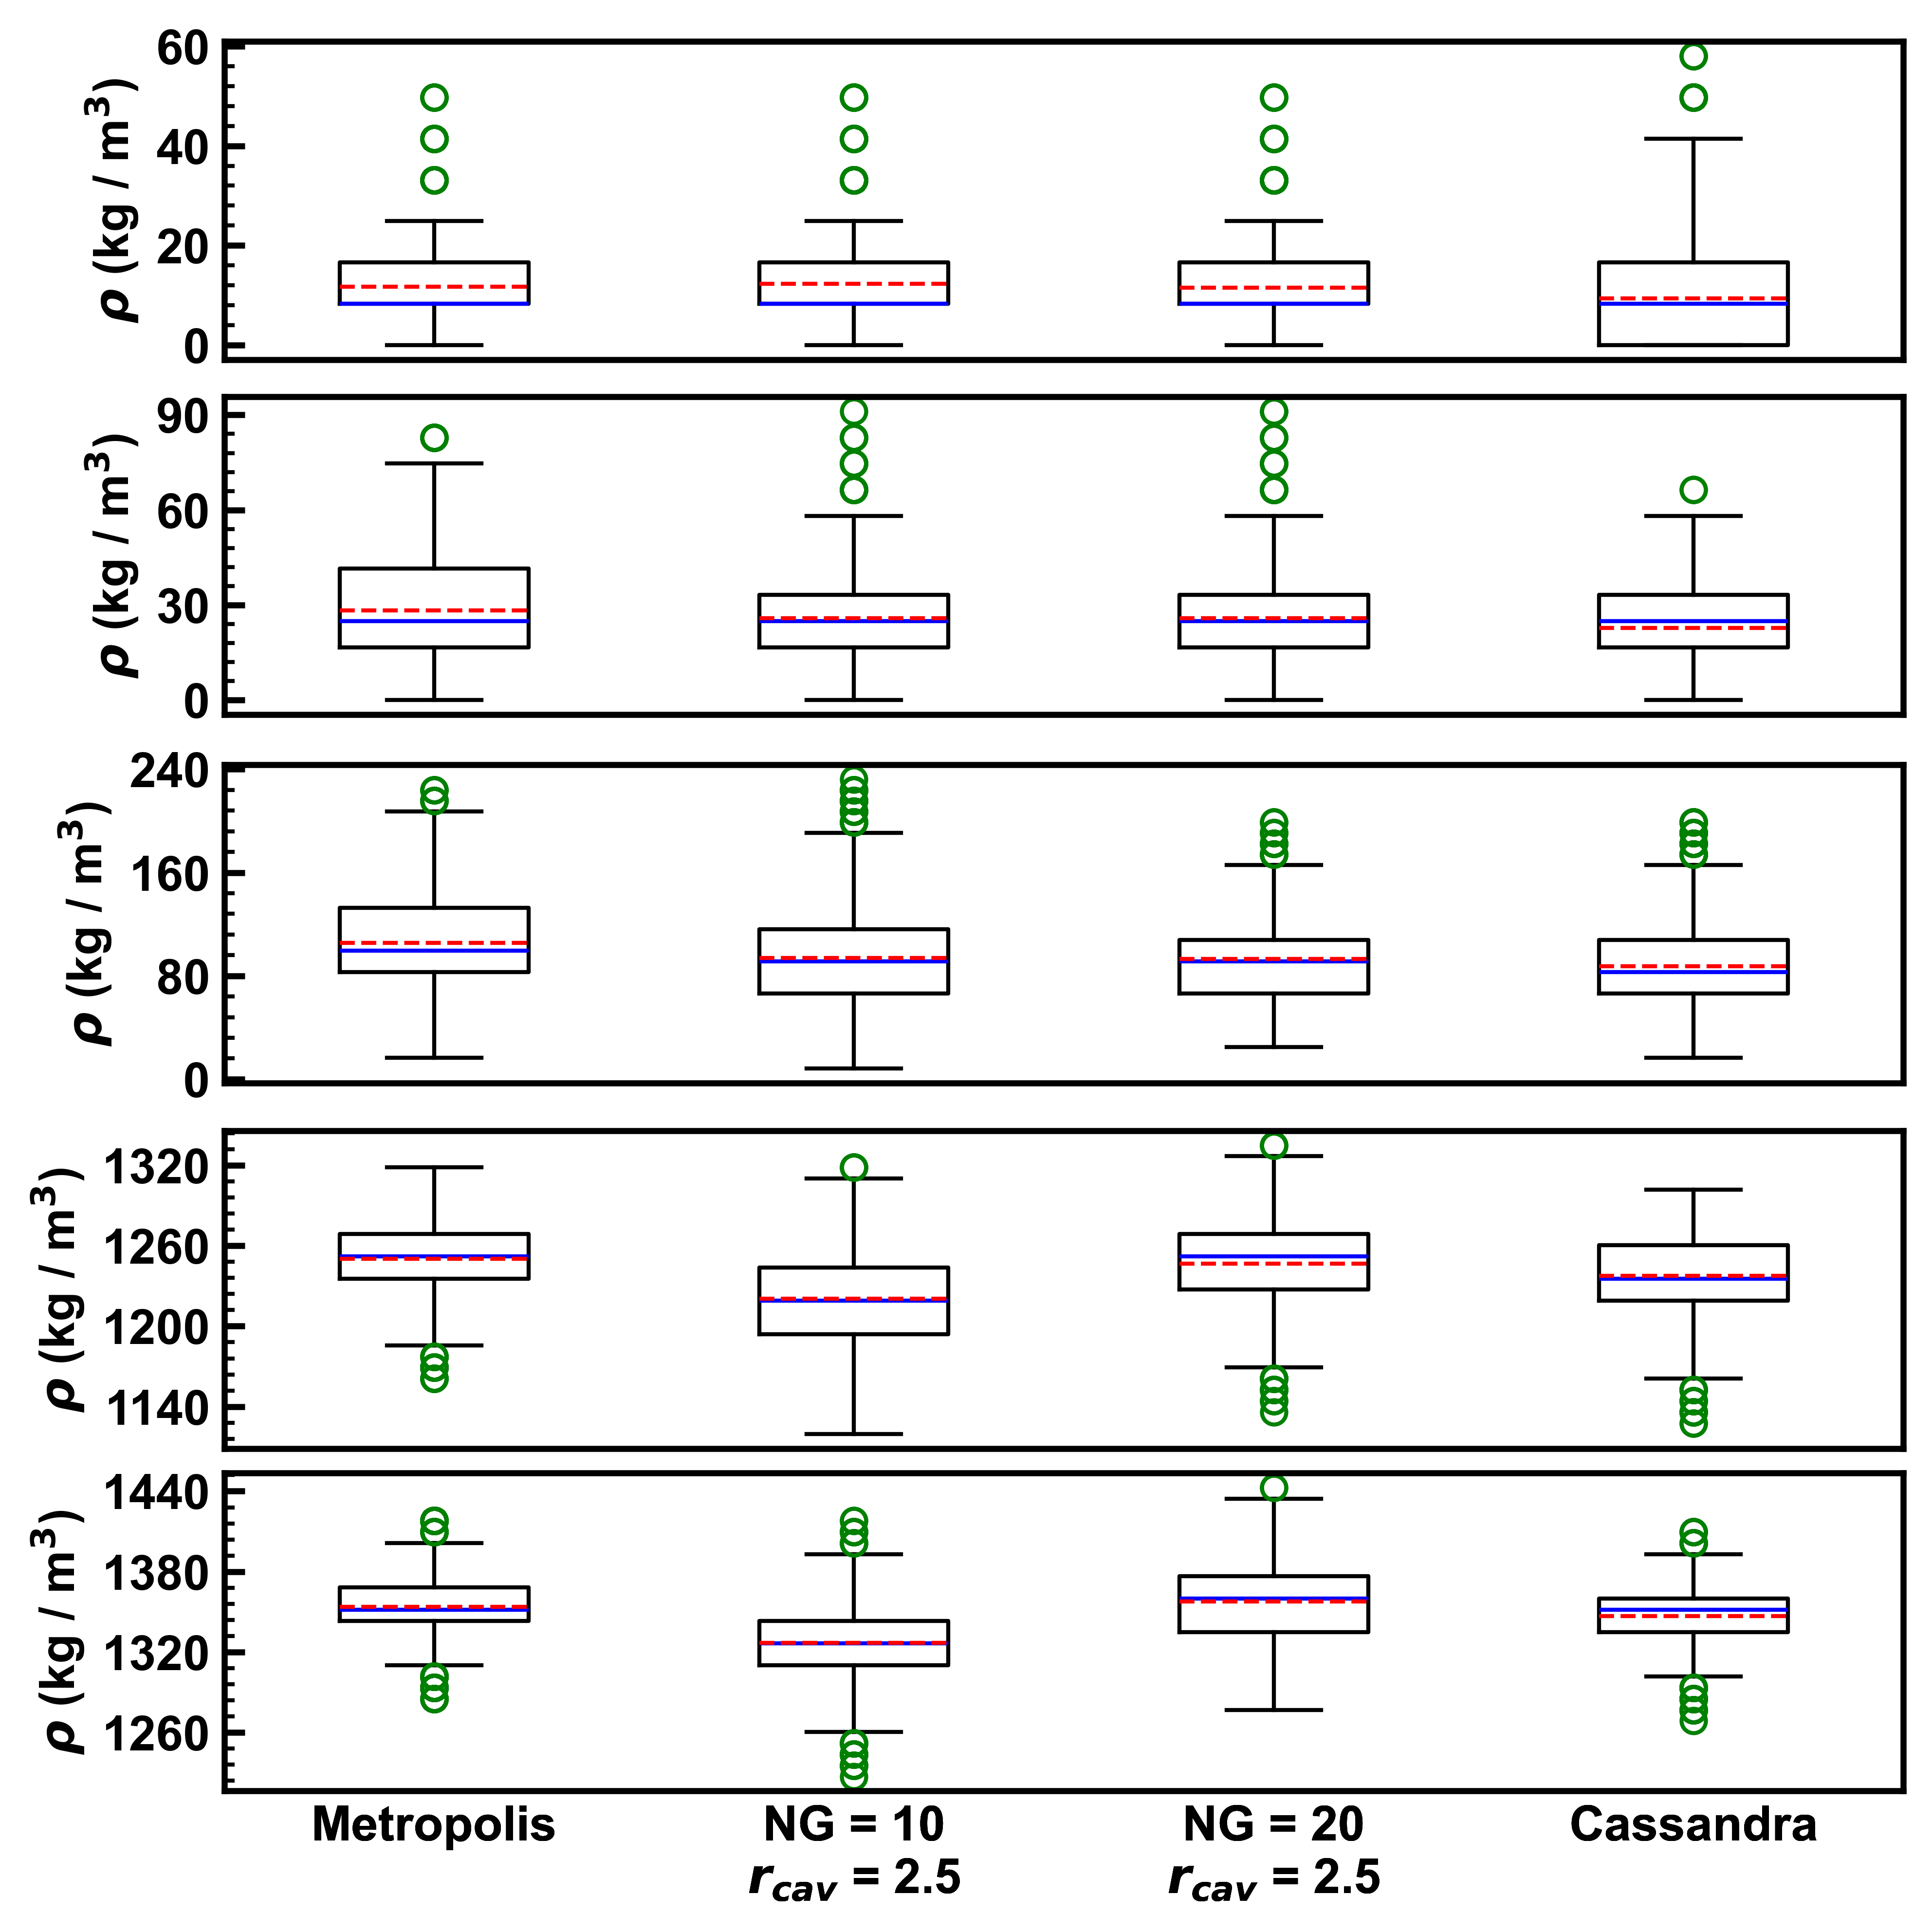

In [ ]:
fig, axs = plt.subplot_mosaic(
    [['B = 0'],['B = 1'], ['B = 2'], ['B = 3'], ['B = 4']], 
    figsize=(6.5, 6.5), dpi=600, 
    sharex = True, sharey = False, 
    layout="constrained"
    )


prefix = "/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/gcmc/argon"



ase_densities = {
    "metropolis": {},
    "gres_10_rcav_2.5": {},
    "gres_10_rcav_4": {}, 
    "gres_20_rcav_2.5": {}, 
    "gres_20_rcav_4": {},  
}


cassandra_densities = {
    "metropolis": {},
    "bias": {},
}


Bs = ["0.0", "1.0", "2.0", "3.0", "4.0"]


for B in Bs:
   ase_densities["metropolis"][B]= np.load(f"{prefix}/classical/asemc/metropolis/{B}/density.npy")
   ase_densities["gres_10_rcav_2.5"][B]= np.load(f"{prefix}/classical/asemc/bias/gres_10_rcav_2.5/{B}/density.npy")
   ase_densities["gres_10_rcav_4"][B]= np.load(f"{prefix}/classical/asemc/bias/gres_10_rcav_4/{B}/density.npy")
   ase_densities["gres_20_rcav_2.5"][B]= np.load(f"{prefix}/classical/asemc/bias/gres_20_rcav_2.5/{B}/density.npy")
   ase_densities["gres_20_rcav_4"][B]= np.load(f"{prefix}/classical/asemc/bias/gres_20_rcav_4/{B}/density.npy")

   if B == "3.0" or B == "4.0":
      cassandra_densities["metropolis"][B]= np.load(f"{prefix}/classical/cassandra/metropolis/{B}/equil.out.prp.Mass_Density.npy")
      cassandra_densities["bias"][B]= np.load(f"{prefix}/classical/cassandra/bias/{B}/equil.out.prp.Mass_Density.npy")
   else:
      cassandra_densities["metropolis"][B]= np.load(f"{prefix}/classical/cassandra/metropolis/{B}/equil.out.prp.Mass_Density.npy")
      cassandra_densities["bias"][B]= np.load(f"{prefix}/classical/cassandra/bias/{B}/equil.out.prp.Mass_Density.npy")

selection = slice(5000,-1,1)
selection_cassandra = slice(5000,-2,1)

labels = ["Metropolis",
          "NG = 10\n$r_{cav}$ = 2.5",
          #"NG = 10\n$r_{cav}$ = 4.0", 
          "NG = 20\n$r_{cav}$ = 2.5",
          #"NG = 20\n$r_{cav}$ = 4.0",
          "Cassandra"     
          ]


data = np.array([
   ase_densities["metropolis"]["0.0"][selection],
   ase_densities["gres_10_rcav_2.5"]["0.0"][selection],
   #ase_densities["gres_10_rcav_4"]["0.0"][selection],
   ase_densities["gres_20_rcav_2.5"]["0.0"][selection],
   #ase_densities["gres_20_rcav_4"]["0.0"][selection],
   cassandra_densities["bias"]["0.0"][selection_cassandra]
   
])
bp0 = axs['B = 0'].boxplot(data.T, tick_labels=labels, showmeans=True, meanline=True, 
                     medianprops={"color":"blue"}, meanprops={"color":"red"}, flierprops={"markeredgecolor":"g"})
print("B = 0")
print("Metropolis: Density = ", np.mean(data[0]), "+/-", np.std(data[0]))
print("N10 R2.5: Density = ", np.mean(data[1]), "+/-", np.std(data[1]))
print("N20 R2.5: Density = ", np.mean(data[2]), "+/-", np.std(data[2]))
print("Cassandra: Density = ", np.mean(data[3]), "+/-", np.std(data[3]))
print()


data = np.array([
   ase_densities["metropolis"]["1.0"][selection],
   ase_densities["gres_10_rcav_2.5"]["1.0"][selection],
   #ase_densities["gres_10_rcav_4"]["1.0"][selection],
   ase_densities["gres_20_rcav_2.5"]["1.0"][selection],
   #ase_densities["gres_20_rcav_4"]["1.0"][selection],
   cassandra_densities["bias"]["1.0"][selection_cassandra]
])

axs['B = 1'].boxplot(data.T, tick_labels=labels, showmeans=True, meanline=True, 
                     medianprops={"color":"blue"}, meanprops={"color":"red"}, flierprops={"markeredgecolor":"g"})

print("B = 1")
print("Metropolis: Density = ", np.mean(data[0]), "+/-", np.std(data[0]))
print("N10 R2.5: Density = ", np.mean(data[1]), "+/-", np.std(data[1]))
print("N20 R2.5: Density = ", np.mean(data[2]), "+/-", np.std(data[2]))
print("Cassandra: Density = ", np.mean(data[3]), "+/-", np.std(data[3]))
print()



data = np.array([
   ase_densities["metropolis"]["2.0"][selection],
   ase_densities["gres_10_rcav_2.5"]["2.0"][selection],
   #ase_densities["gres_10_rcav_4"]["2.0"][selection],
   ase_densities["gres_20_rcav_2.5"]["2.0"][selection],
   #ase_densities["gres_20_rcav_4"]["2.0"][selection],
   cassandra_densities["bias"]["2.0"][selection_cassandra]
])
axs['B = 2'].boxplot(data.T, tick_labels=labels, showmeans=True, meanline=True, 
                     medianprops={"color":"blue"}, meanprops={"color":"red"}, flierprops={"markeredgecolor":"g"})


print("B = 2")
print("Metropolis: Density = ", np.mean(data[0]), "+/-", np.std(data[0]))
print("N10 R2.5: Density = ", np.mean(data[1]), "+/-", np.std(data[1]))
print("N20 R2.5: Density = ", np.mean(data[2]), "+/-", np.std(data[2]))
print("Cassandra: Density = ", np.mean(data[3]), "+/-", np.std(data[3]))
print()



data = np.array([
   ase_densities["metropolis"]["3.0"][selection],
   ase_densities["gres_10_rcav_2.5"]["3.0"][selection],
   #ase_densities["gres_10_rcav_4"]["3.0"][selection],
   ase_densities["gres_20_rcav_2.5"]["3.0"][selection],
   #ase_densities["gres_20_rcav_4"]["3.0"][selection],
   cassandra_densities["bias"]["3.0"][0::50][selection_cassandra]
])
axs['B = 3'].boxplot(data.T, tick_labels=labels, showmeans=True, meanline=True, 
                     medianprops={"color":"blue"}, meanprops={"color":"red"}, flierprops={"markeredgecolor":"g"})

print("B = 3")
print("Metropolis: Density = ", np.mean(data[0]), "+/-", np.std(data[0]))
print("N10 R2.5: Density = ", np.mean(data[1]), "+/-", np.std(data[1]))
print("N20 R2.5: Density = ", np.mean(data[2]), "+/-", np.std(data[2]))
print("Cassandra: Density = ", np.mean(data[3]), "+/-", np.std(data[3]))
print()



data = np.array([
   ase_densities["metropolis"]["4.0"][selection],
   ase_densities["gres_10_rcav_2.5"]["4.0"][selection],
   #ase_densities["gres_10_rcav_4"]["4.0"][selection],
   ase_densities["gres_20_rcav_2.5"]["4.0"][selection],
   #ase_densities["gres_20_rcav_4"]["4.0"][selection],
   cassandra_densities["bias"]["4.0"][0::50][selection_cassandra]
])
axs['B = 4'].boxplot(data.T, tick_labels=labels, showmeans=True, meanline=True, 
                     medianprops={"color":"blue"}, meanprops={"color":"red"}, flierprops={"markeredgecolor":"g"})


print("B = 4")
print("Metropolis: Density = ", np.mean(data[0]), "+/-", np.std(data[0]))
print("N10 R2.5: Density = ", np.mean(data[1]), "+/-", np.std(data[1]))
print("N20 R2.5: Density = ", np.mean(data[2]), "+/-", np.std(data[2]))
print("Cassandra: Density = ", np.mean(data[3]), "+/-", np.std(data[3]))
print()


for key, value in axs.items():
   axs[key].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
   axs[key].yaxis.set_major_locator(mpl.ticker.MaxNLocator(4))
   axs[key].set_ylabel(r"$\rho$ (kg / m$^3$)")
   axs[key].tick_params(axis='x', which='both', width=0,)# rotation=45)


save_figure(fig, prefix="argon-sensitivity-density_boxandwhisker")

B = 0
Metropolis: Density =  11.727094420383564 +/- 8.519359695005965
N10 R2.5: Density =  12.262858422898965 +/- 8.844518174331471
N10 R4: Density =  10.801533078576767 +/- 7.6302811109128195
N20 R2.5: Density =  11.52804897053264 +/- 8.516572181933292
N20 R4: Density =  11.338955793174263 +/- 8.046899035689977
Cassandra: Density =  9.338554391278254 +/- 9.693177211907704

B = 1
Metropolis: Density =  28.297628120472925 +/- 15.740309476734225
N10 R2.5: Density =  25.89083688935884 +/- 14.872950634618487
N10 R4: Density =  23.583568383170224 +/- 12.803937756159948
N20 R2.5: Density =  25.86263878396329 +/- 14.12794245184345
N20 R4: Density =  25.134464179925335 +/- 13.854139239347958
Cassandra: Density =  22.74924920844169 +/- 13.034761179386171

B = 2
Metropolis: Density =  105.48247743641468 +/- 34.705109023100974
N10 R2.5: Density =  93.81675536306848 +/- 36.18811240958237
N10 R4: Density =  69.43368775633039 +/- 27.794378163167018
N20 R2.5: Density =  93.01891485158271 +/- 30.87933

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


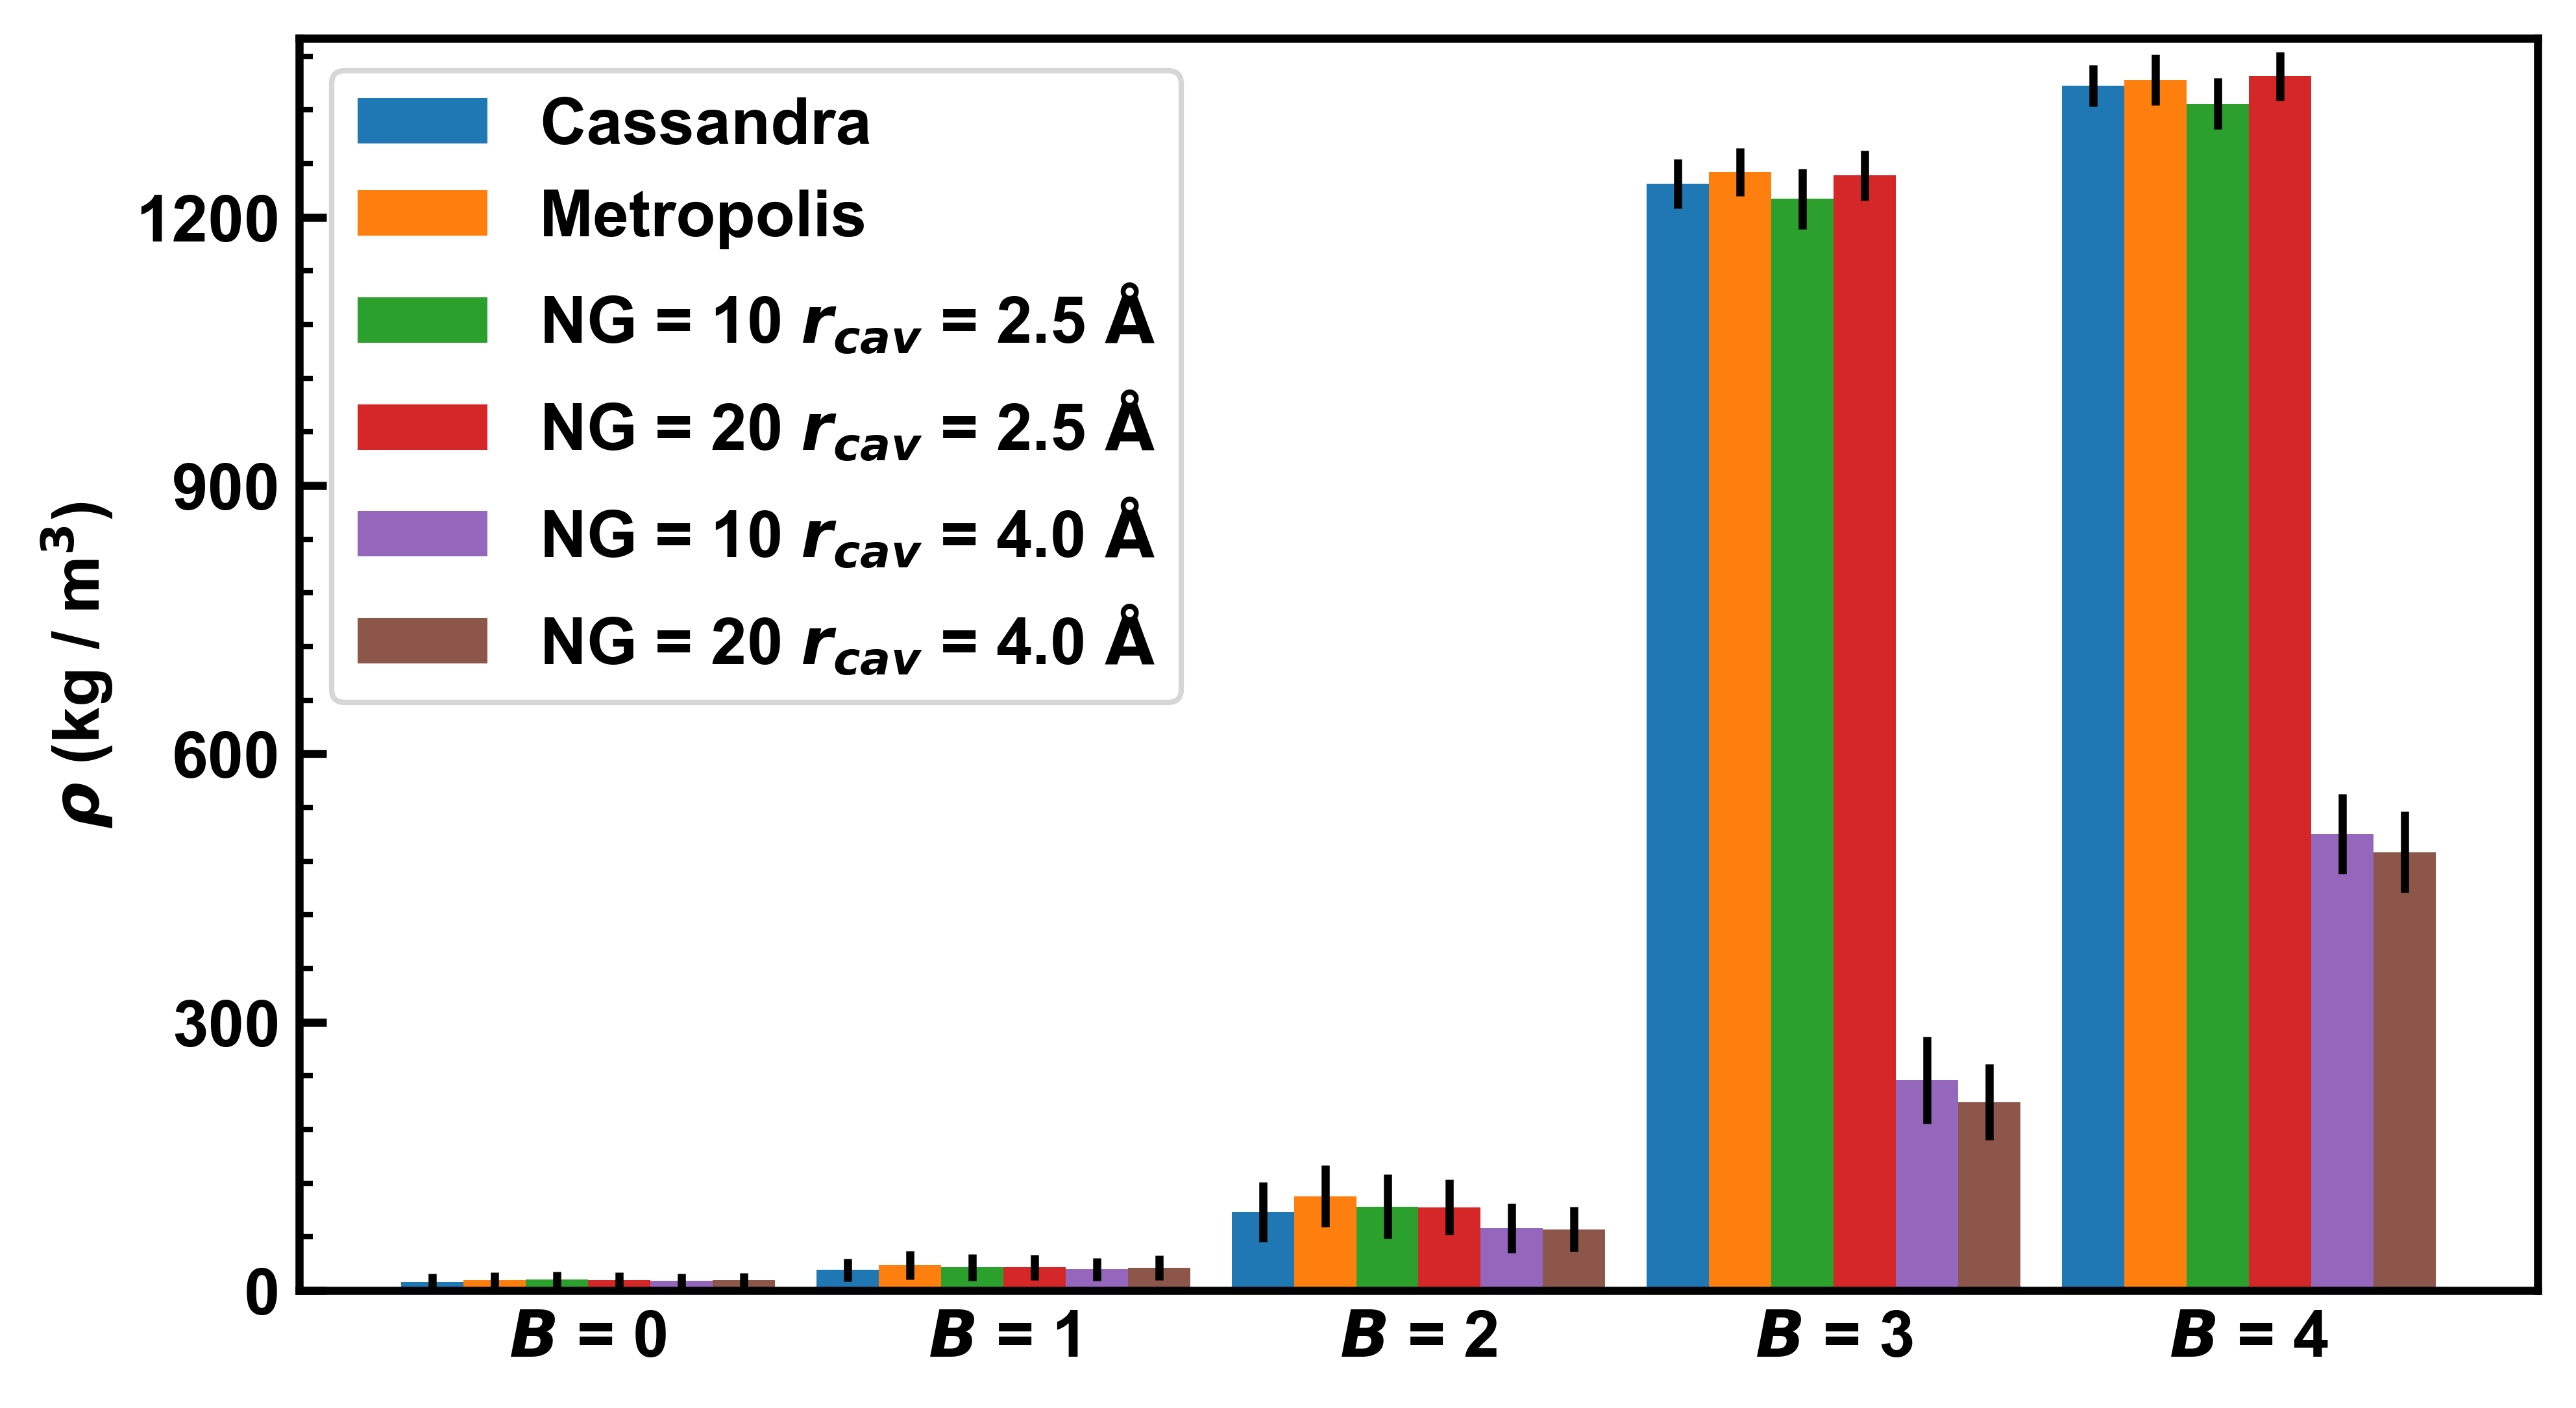

In [3]:
fig, axs = plt.subplot_mosaic(
    [['a)']], 
    figsize=(6.5, 3.5), dpi=600, 
    sharex = True, sharey = False, 
    layout="constrained"
    )


prefix = "/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/gcmc/argon"

ase_densities = {
    "metropolis": {},
    "gres_10_rcav_2.5": {},
    "gres_10_rcav_4": {}, 
    "gres_20_rcav_2.5": {}, 
    "gres_20_rcav_4": {},  
}


cassandra_densities = {
    "metropolis": {},
    "bias": {},
}


Bs = ["0.0", "1.0", "2.0", "3.0", "4.0"]


for B in Bs:
   ase_densities["metropolis"][B]= np.load(f"{prefix}/classical/asemc/metropolis/{B}/density.npy")
   ase_densities["gres_10_rcav_2.5"][B]= np.load(f"{prefix}/classical/asemc/bias/gres_10_rcav_2.5/{B}/density.npy")
   ase_densities["gres_10_rcav_4"][B]= np.load(f"{prefix}/classical/asemc/bias/gres_10_rcav_4/{B}/density.npy")
   ase_densities["gres_20_rcav_2.5"][B]= np.load(f"{prefix}/classical/asemc/bias/gres_20_rcav_2.5/{B}/density.npy")
   ase_densities["gres_20_rcav_4"][B]= np.load(f"{prefix}/classical/asemc/bias/gres_20_rcav_4/{B}/density.npy")

   if B == "3.0" or B == "4.0":
      cassandra_densities["metropolis"][B]= np.load(f"{prefix}/classical/cassandra/metropolis/{B}/equil.out.prp.Mass_Density.npy")
      cassandra_densities["bias"][B]= np.load(f"{prefix}/classical/cassandra/bias/{B}/equil.out.prp.Mass_Density.npy")
   else:
      cassandra_densities["metropolis"][B]= np.load(f"{prefix}/classical/cassandra/metropolis/{B}/equil.out.prp.Mass_Density.npy")
      cassandra_densities["bias"][B]= np.load(f"{prefix}/classical/cassandra/bias/{B}/equil.out.prp.Mass_Density.npy")

selection = slice(5000,-1,1)
selection_cassandra = slice(5000,-2,1)

labels = ["Metropolis",
          "NG = 10\n$r_{cav}$ = 2.5",
          "NG = 10\n$r_{cav}$ = 4.0", 
          "NG = 20\n$r_{cav}$ = 2.5",
          "NG = 20\n$r_{cav}$ = 4.0",
          "Cassandra"     
          ]


data0 = np.array([
   ase_densities["metropolis"]["0.0"][selection],
   ase_densities["gres_10_rcav_2.5"]["0.0"][selection],
   ase_densities["gres_10_rcav_4"]["0.0"][selection],
   ase_densities["gres_20_rcav_2.5"]["0.0"][selection],
   ase_densities["gres_20_rcav_4"]["0.0"][selection],
   cassandra_densities["bias"]["0.0"][selection_cassandra]
   
])
print("B = 0")
print("Metropolis: Density = ", np.mean(data0[0]), "+/-", np.std(data0[0]))
print("N10 R2.5: Density = ", np.mean(data0[1]), "+/-", np.std(data0[1]))
print("N10 R4: Density = ", np.mean(data0[2]), "+/-", np.std(data0[2]))
print("N20 R2.5: Density = ", np.mean(data0[3]), "+/-", np.std(data0[3]))
print("N20 R4: Density = ", np.mean(data0[4]), "+/-", np.std(data0[4]))
print("Cassandra: Density = ", np.mean(data0[5]), "+/-", np.std(data0[5]))
print()


data1 = np.array([
   ase_densities["metropolis"]["1.0"][selection],
   ase_densities["gres_10_rcav_2.5"]["1.0"][selection],
   ase_densities["gres_10_rcav_4"]["1.0"][selection],
   ase_densities["gres_20_rcav_2.5"]["1.0"][selection],
   ase_densities["gres_20_rcav_4"]["1.0"][selection],
   cassandra_densities["bias"]["1.0"][selection_cassandra]
])


print("B = 1")
print("Metropolis: Density = ", np.mean(data1[0]), "+/-", np.std(data1[0]))
print("N10 R2.5: Density = ", np.mean(data1[1]), "+/-", np.std(data1[1]))
print("N10 R4: Density = ", np.mean(data1[2]), "+/-", np.std(data1[2]))
print("N20 R2.5: Density = ", np.mean(data1[3]), "+/-", np.std(data1[3]))
print("N20 R4: Density = ", np.mean(data1[4]), "+/-", np.std(data1[4]))
print("Cassandra: Density = ", np.mean(data1[5]), "+/-", np.std(data1[5]))
print()



data2 = np.array([
   ase_densities["metropolis"]["2.0"][selection],
   ase_densities["gres_10_rcav_2.5"]["2.0"][selection],
   ase_densities["gres_10_rcav_4"]["2.0"][selection],
   ase_densities["gres_20_rcav_2.5"]["2.0"][selection],
   ase_densities["gres_20_rcav_4"]["2.0"][selection],
   cassandra_densities["bias"]["2.0"][selection_cassandra]
])


print("B = 2")
print("Metropolis: Density = ", np.mean(data2[0]), "+/-", np.std(data2[0]))
print("N10 R2.5: Density = ", np.mean(data2[1]), "+/-", np.std(data2[1]))
print("N10 R4: Density = ", np.mean(data2[2]), "+/-", np.std(data2[2]))
print("N20 R2.5: Density = ", np.mean(data2[3]), "+/-", np.std(data2[3]))
print("N20 R4: Density = ", np.mean(data2[4]), "+/-", np.std(data2[4]))
print("Cassandra: Density = ", np.mean(data2[5]), "+/-", np.std(data2[5]))
print()



data3 = np.array([
   ase_densities["metropolis"]["3.0"][selection],
   ase_densities["gres_10_rcav_2.5"]["3.0"][selection],
   ase_densities["gres_10_rcav_4"]["3.0"][selection],
   ase_densities["gres_20_rcav_2.5"]["3.0"][selection],
   ase_densities["gres_20_rcav_4"]["3.0"][selection],
   cassandra_densities["bias"]["3.0"][0::50][selection_cassandra]
])
print("B = 3")
print("Metropolis: Density = ", np.mean(data3[0]), "+/-", np.std(data3[0]))
print("N10 R2.5: Density = ", np.mean(data3[1]), "+/-", np.std(data3[1]))
print("N10 R4: Density = ", np.mean(data3[2]), "+/-", np.std(data3[2]))
print("N20 R2.5: Density = ", np.mean(data3[3]), "+/-", np.std(data3[3]))
print("N20 R4: Density = ", np.mean(data3[4]), "+/-", np.std(data3[4]))
print("Cassandra: Density = ", np.mean(data3[5]), "+/-", np.std(data3[5]))
print()



data4 = np.array([
   ase_densities["metropolis"]["4.0"][selection],
   ase_densities["gres_10_rcav_2.5"]["4.0"][selection],
   ase_densities["gres_10_rcav_4"]["4.0"][selection],
   ase_densities["gres_20_rcav_2.5"]["4.0"][selection],
   ase_densities["gres_20_rcav_4"]["4.0"][selection],
   cassandra_densities["bias"]["4.0"][0::50][selection_cassandra]
])

print("B = 4")
print("Metropolis: Density = ", np.mean(data4[0]), "+/-", np.std(data4[0]))
print("N10 R2.5: Density = ", np.mean(data4[1]), "+/-", np.std(data4[1]))
print("N10 R4: Density = ", np.mean(data4[2]), "+/-", np.std(data4[2]))
print("N20 R2.5: Density = ", np.mean(data4[3]), "+/-", np.std(data4[3]))
print("N20 R4: Density = ", np.mean(data4[4]), "+/-", np.std(data4[4]))
print("Cassandra: Density = ", np.mean(data4[5]), "+/-", np.std(data4[5]))
print()



rho_means_metropolis = [np.mean(data0[0]), np.mean(data1[0]), np.mean(data2[0]), np.mean(data3[0]), np.mean(data4[0])  ]
rho_err_metropolis = [np.std(data0[0]), np.std(data1[0]), np.std(data2[0]), np.std(data3[0]), np.std(data4[0])  ]


rho_means_N10R25= [np.mean(data0[1]), np.mean(data1[1]), np.mean(data2[1]), np.mean(data3[1]), np.mean(data4[1])  ]
rho_err_N10R25 = [np.std(data0[1]), np.std(data1[1]), np.std(data2[1]), np.std(data3[1]), np.std(data4[1])  ]


rho_means_N10R4= [np.mean(data0[2]), np.mean(data1[2]), np.mean(data2[2]), np.mean(data3[2]), np.mean(data4[2])  ]
rho_err_N10R4 = [np.std(data0[2]), np.std(data1[2]), np.std(data2[2]), np.std(data3[2]), np.std(data4[2])  ]


rho_means_N20R25= [np.mean(data0[3]), np.mean(data1[3]), np.mean(data2[3]), np.mean(data3[3]), np.mean(data4[3])  ]
rho_err_N20R25 = [np.std(data0[3]), np.std(data1[3]), np.std(data2[3]), np.std(data3[3]), np.std(data4[3])  ]


rho_means_N20R4= [np.mean(data0[4]), np.mean(data1[4]), np.mean(data2[4]), np.mean(data3[4]), np.mean(data4[4])  ]
rho_err_N20R4 = [np.std(data0[4]), np.std(data1[4]), np.std(data2[4]), np.std(data3[4]), np.std(data4[4])  ]

rho_means_cassandra = [np.mean(data0[5]), np.mean(data1[5]), np.mean(data2[5]), np.mean(data3[5]), np.mean(data4[5])  ]
rho_err_cassandra  = [np.std(data0[5]), np.std(data1[5]), np.std(data2[5]), np.std(data3[5]), np.std(data4[5])  ]


ind = np.arange(len(rho_means_metropolis))  # the x locations for the groups
width = 0.15  # the width of the bars

'''
rects1 = axs["a)"].bar(ind - 5*width/2, rho_means_metropolis, width, yerr=rho_err_metropolis,
                label='Metropolis')
rects2 = axs["a)"].bar(ind - 3*width/2, rho_means_N10R25, width, yerr=rho_err_N10R25,
                label='NG = 10\n$r_{cav}$ = 2.5')
rects3 = axs["a)"].bar(ind - width/2, rho_means_N10R4, width, yerr=rho_err_N10R4,
                label='NG = 10\n$r_{cav}$ = 4.0')
rects4 = axs["a)"].bar(ind + width/2, rho_means_N20R25, width, yerr=rho_err_N20R25,
                label='NG = 20\n$r_{cav}$ = 2.5')
rects5 = axs["a)"].bar(ind + 3*width/2, rho_means_N20R4, width, yerr=rho_err_N20R4,
                label='NG = 20\n$r_{cav}$ = 4.0')
rects6 = axs["a)"].bar(ind + 5*width/2, rho_means_cassandra, width, yerr=rho_err_cassandra,
                label='Cassandra')
'''

rects6 = axs["a)"].bar(ind - 5*width/2, rho_means_cassandra, width, yerr=rho_err_cassandra,
                label='Cassandra')
rects1 = axs["a)"].bar(ind - 3*width/2, rho_means_metropolis, width, yerr=rho_err_metropolis,
                label='Metropolis')
rects2 = axs["a)"].bar(ind - 1*width/2, rho_means_N10R25, width, yerr=rho_err_N10R25,
                label='NG = 10 $r_{cav}$ = 2.5 $\mathrm{\AA}$')
rects4 = axs["a)"].bar(ind + 1*width/2, rho_means_N20R25, width, yerr=rho_err_N20R25,
                label='NG = 20 $r_{cav}$ = 2.5 $\mathrm{\AA}$')

rects3 = axs["a)"].bar(ind + 3* width/2, rho_means_N10R4, width, yerr=rho_err_N10R4,
                label='NG = 10 $r_{cav}$ = 4.0 $\mathrm{\AA}$')
rects5 = axs["a)"].bar(ind + 5*width/2, rho_means_N20R4, width, yerr=rho_err_N20R4,
                label='NG = 20 $r_{cav}$ = 4.0 $\mathrm{\AA}$')


# Add some text for labels, title and custom x-axis tick labels, etc.
axs["a)"].set_ylabel(r"$\rho$ (kg / m$^3$)")
axs["a)"].set_xticks(ind)
axs["a)"].set_xticklabels(('$B$ = 0', '$B$ = 1', '$B$ = 2', '$B$ = 3', '$B$ = 4'))
axs["a)"].legend()

axs["a)"].set_ylim((0,1400))

axs["a)"].tick_params(axis='x', which='both', width=0,)

axs["a)"].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
axs["a)"].yaxis.set_major_locator(mpl.ticker.MaxNLocator(5))


save_figure(fig, prefix="argon-validation")

# NH3 adsorption over Pt(111)

sj EOS
227.74412303418518 GPa
-24.138026098819296 eV
3.973405370628362 Angstrom


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


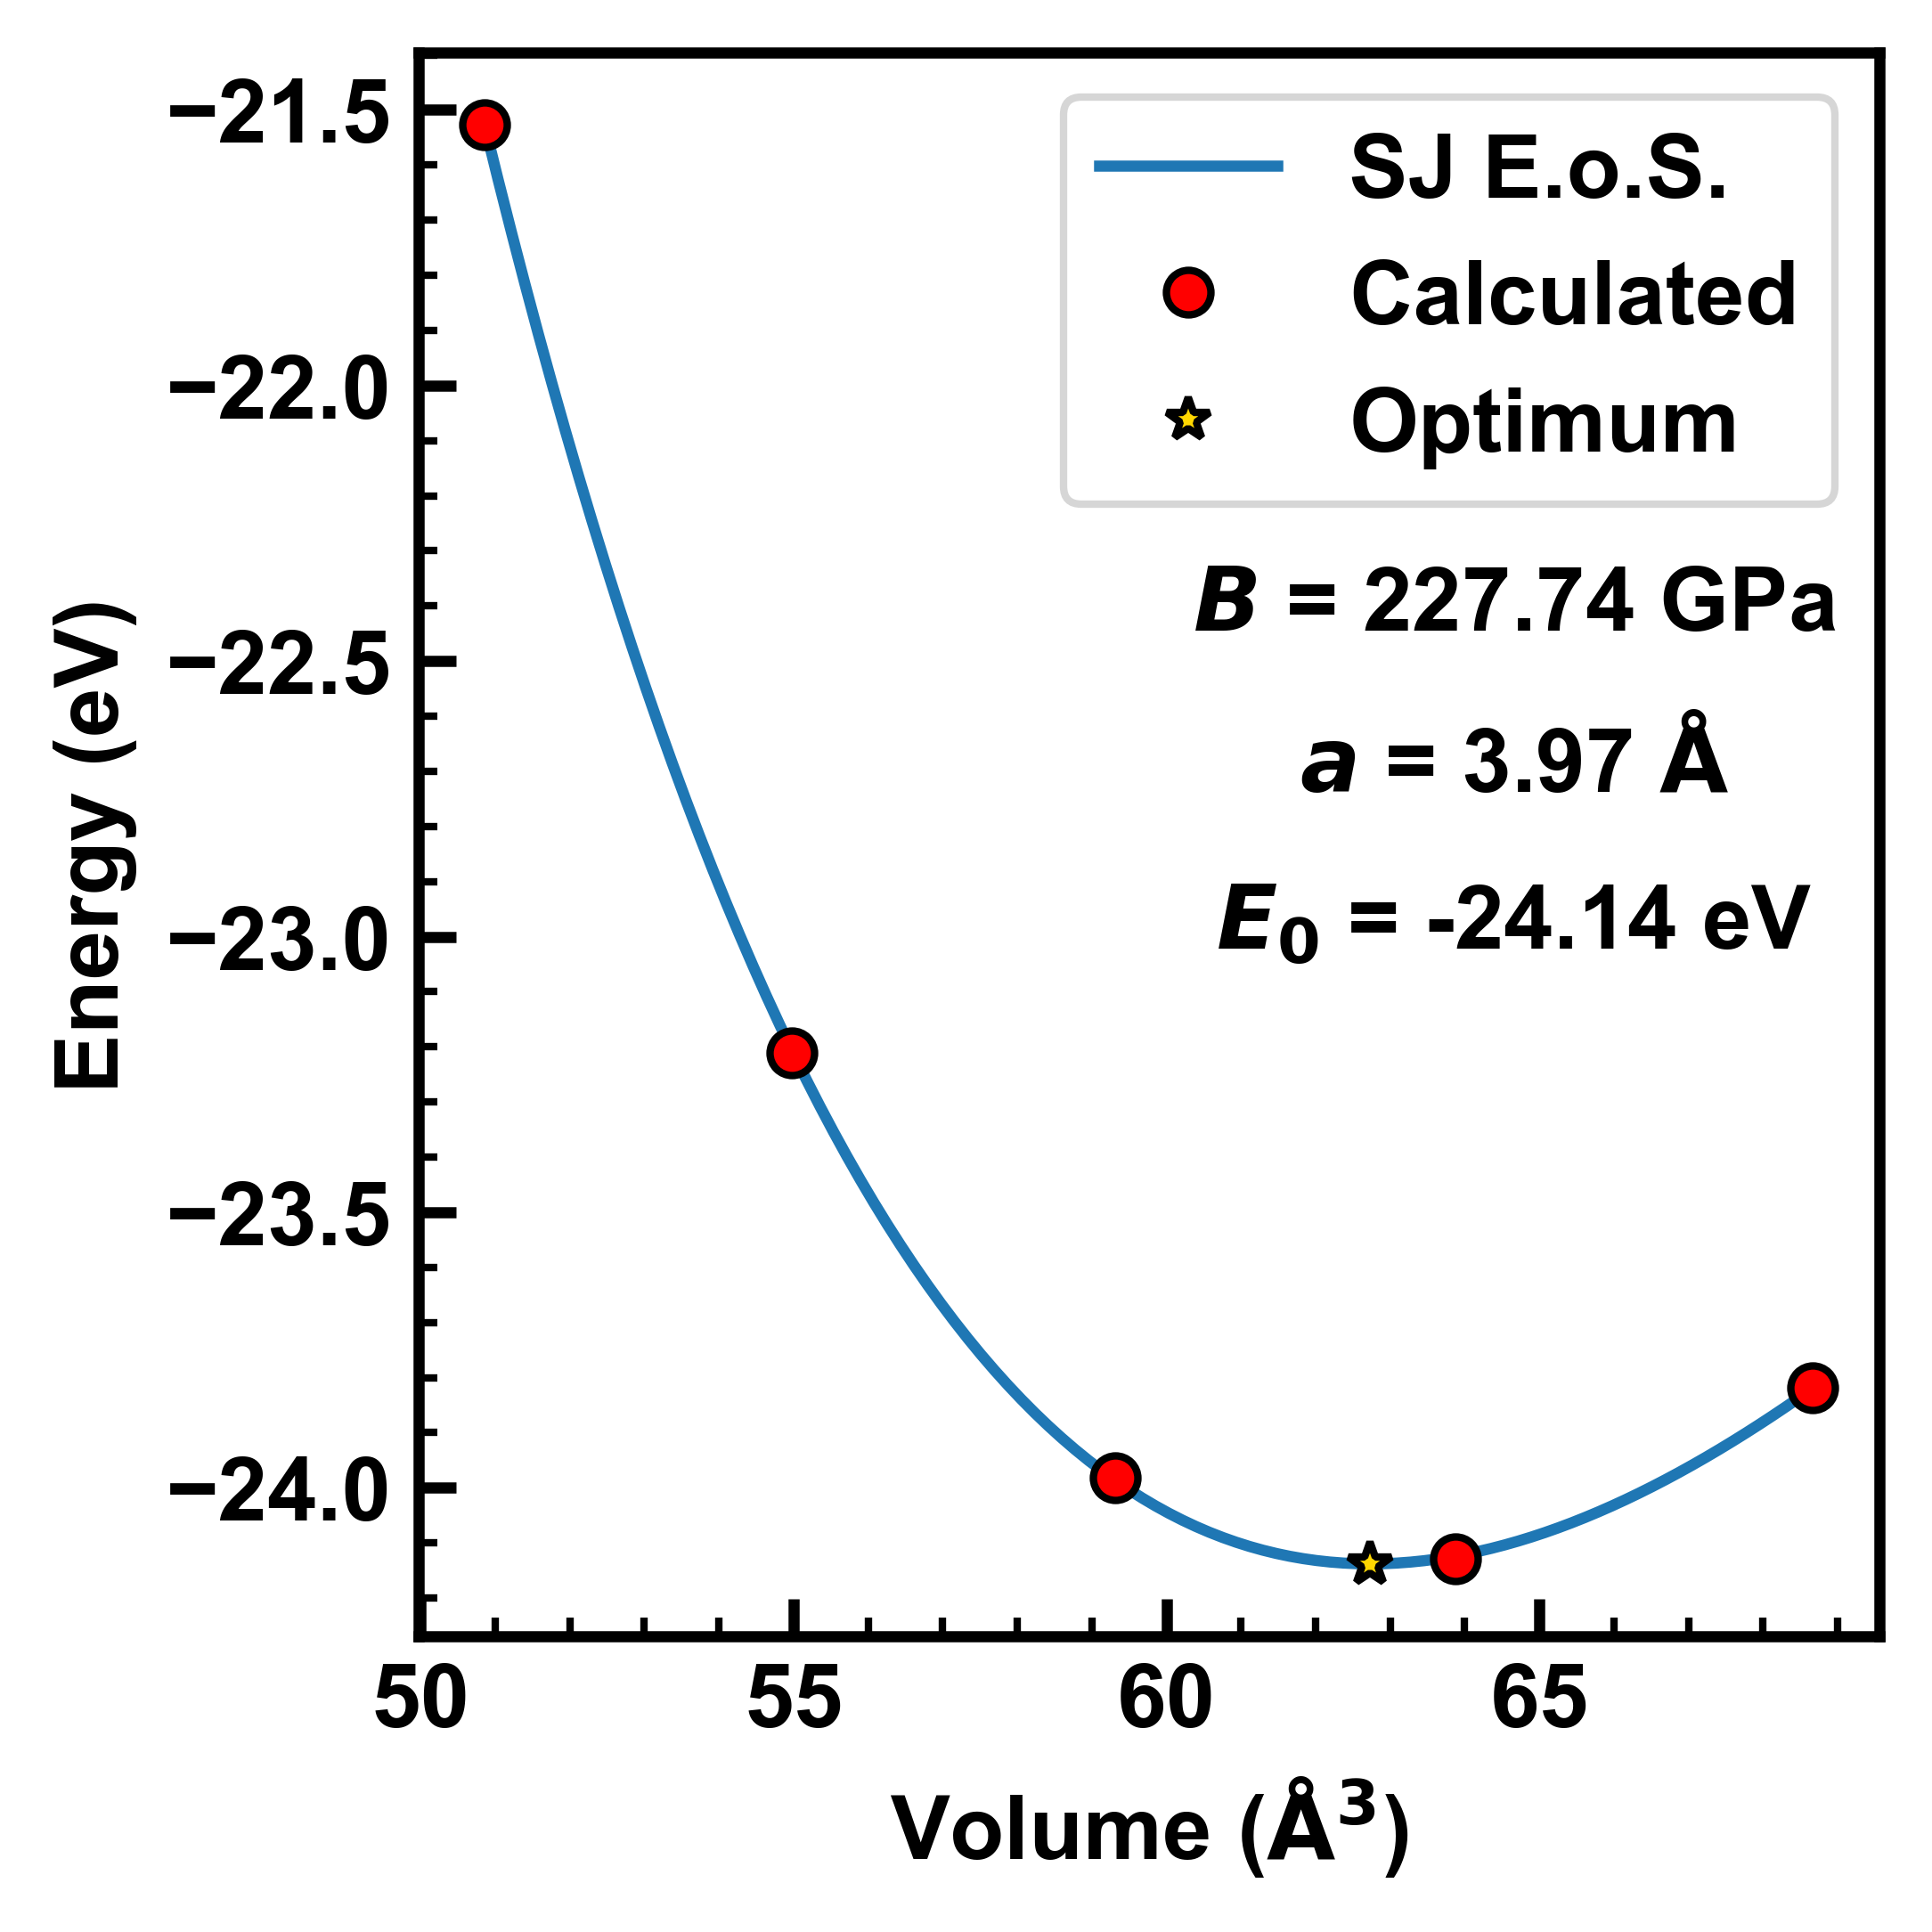

In [47]:
from ase.eos import EquationOfState
from ase import units

fig, axs = plt.subplot_mosaic(
    [['a)'],], 
    figsize=(3.5, 3.5), dpi=600, 
    sharex = False, sharey = True, 
    layout="constrained"
    )


configs = Trajectory("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/gcmc/nh3-Pt/equation_of_state/eos.traj", "r")

volumes = [atoms.get_volume() for atoms in configs]
energies = [atoms.get_potential_energy() for atoms in configs]
eos = EquationOfState(volumes, energies)

eos_string, e0, v0, B, x, y, v, e = eos.getplotdata()

print(eos_string, "EOS")
B = B / units.kJ * 1.0e24
a = v0**(1./3.)
print(B, 'GPa')
print(e0, "eV")
print(a, "Angstrom")

axs["a)"].plot(x,y, label="SJ E.o.S.")
axs["a)"].plot(v,e, marker="o", linewidth=0, color="r", markeredgecolor="k", label="Calculated")
axs["a)"].plot(v0,e0, marker="*", linewidth=0, color="gold",markeredgecolor="k", label="Optimum")
axs["a)"].legend()

axs["a)"].text(x = 0.75, y = 0.65, s = f"$B$ = {B:.2f} GPa",
               horizontalalignment='center',
               verticalalignment='center',
               transform = axs["a)"].transAxes
               )

axs["a)"].text(x = 0.75, y = 0.55, s = f"$a$ = {a:.2f}" +r" $\mathrm{\AA}$",
               horizontalalignment='center',
               verticalalignment='center',
               transform = axs["a)"].transAxes
               )



axs["a)"].text(x = 0.75, y = 0.45, s = f"$E_0$ = {e0:.2f}" +r" eV",
               horizontalalignment='center',
               verticalalignment='center',
               transform = axs["a)"].transAxes
               )

axs["a)"].set_xlabel(r'Volume ($\mathrm{\AA}^3$)')
axs["a)"].set_ylabel(r'Energy (eV)')

#eos.plot(ax=axs["a)"])
#eos.plot('eos.png')


save_figure(fig, prefix="Pt-EoS")



Coverage: 19.785 +/- 4.156962532907893


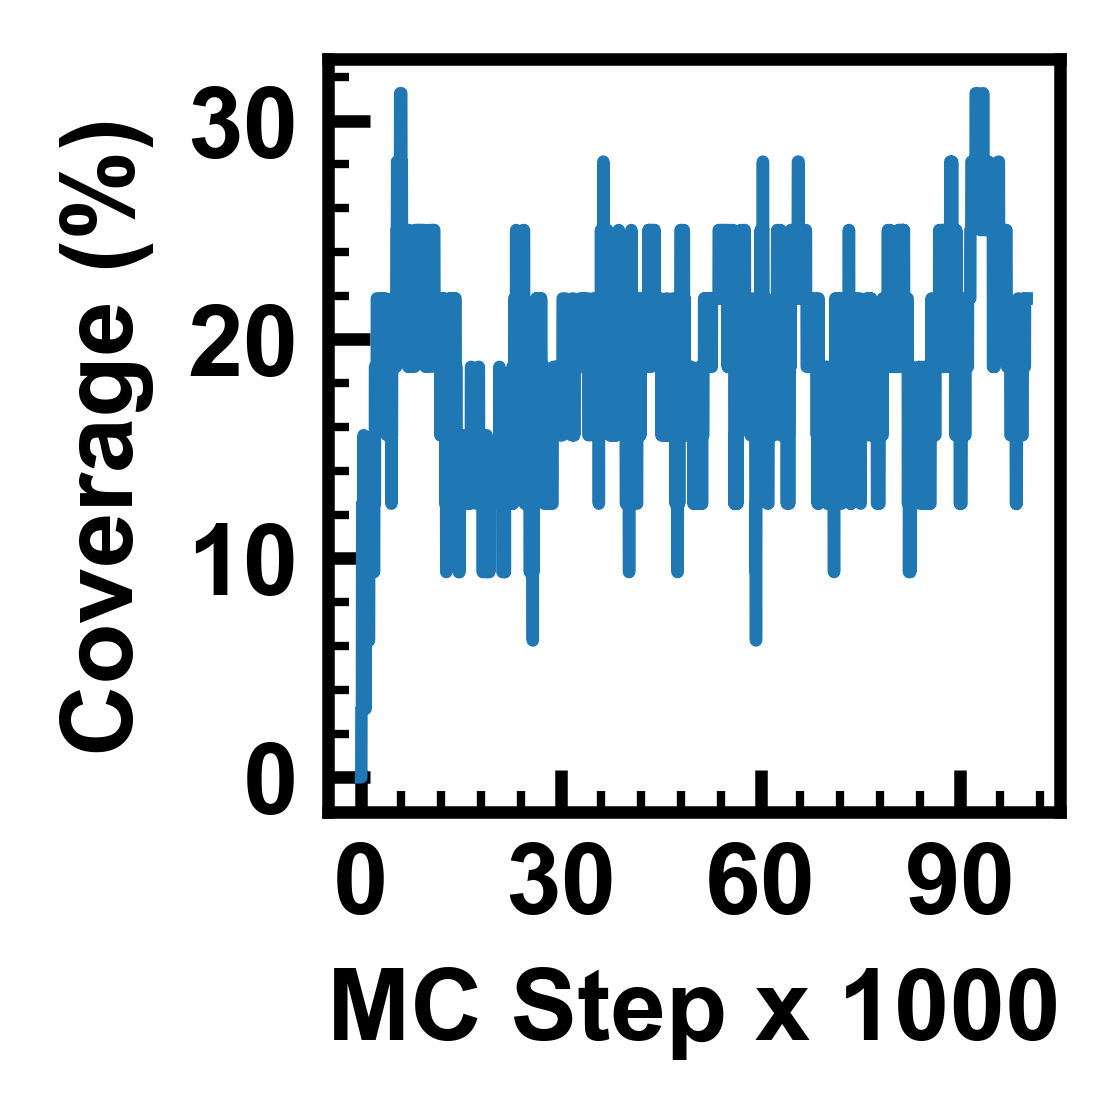

In [67]:
from ase.eos import EquationOfState
from ase import units

fig, axs = plt.subplot_mosaic(
    [['a)'],], 
    figsize=(3.5/2.0, 3.5/2.0), dpi=600, 
    sharex = False, sharey = True, 
    layout="constrained"
    )

coverage = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/gcmc/nh3-Pt/coverage/coverage.npy")
step = np.arange(len(coverage)) * 20

avg = np.mean(coverage[len(coverage)//2:])
std = np.std(coverage[len(coverage)//2:]) 

print(f"Coverage: {avg} +/- {std}")

axs["a)"].plot(step /1000,coverage)
axs["a)"].set_xlabel(r'MC Step x 1000')
axs["a)"].set_ylabel(r'Coverage (%)')

for key, value in axs.items():
    set_ticks(axs[key], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 4)

save_figure(fig, prefix="coverage-manuscript")



Coverage: 19.785 +/- 4.156962532907893


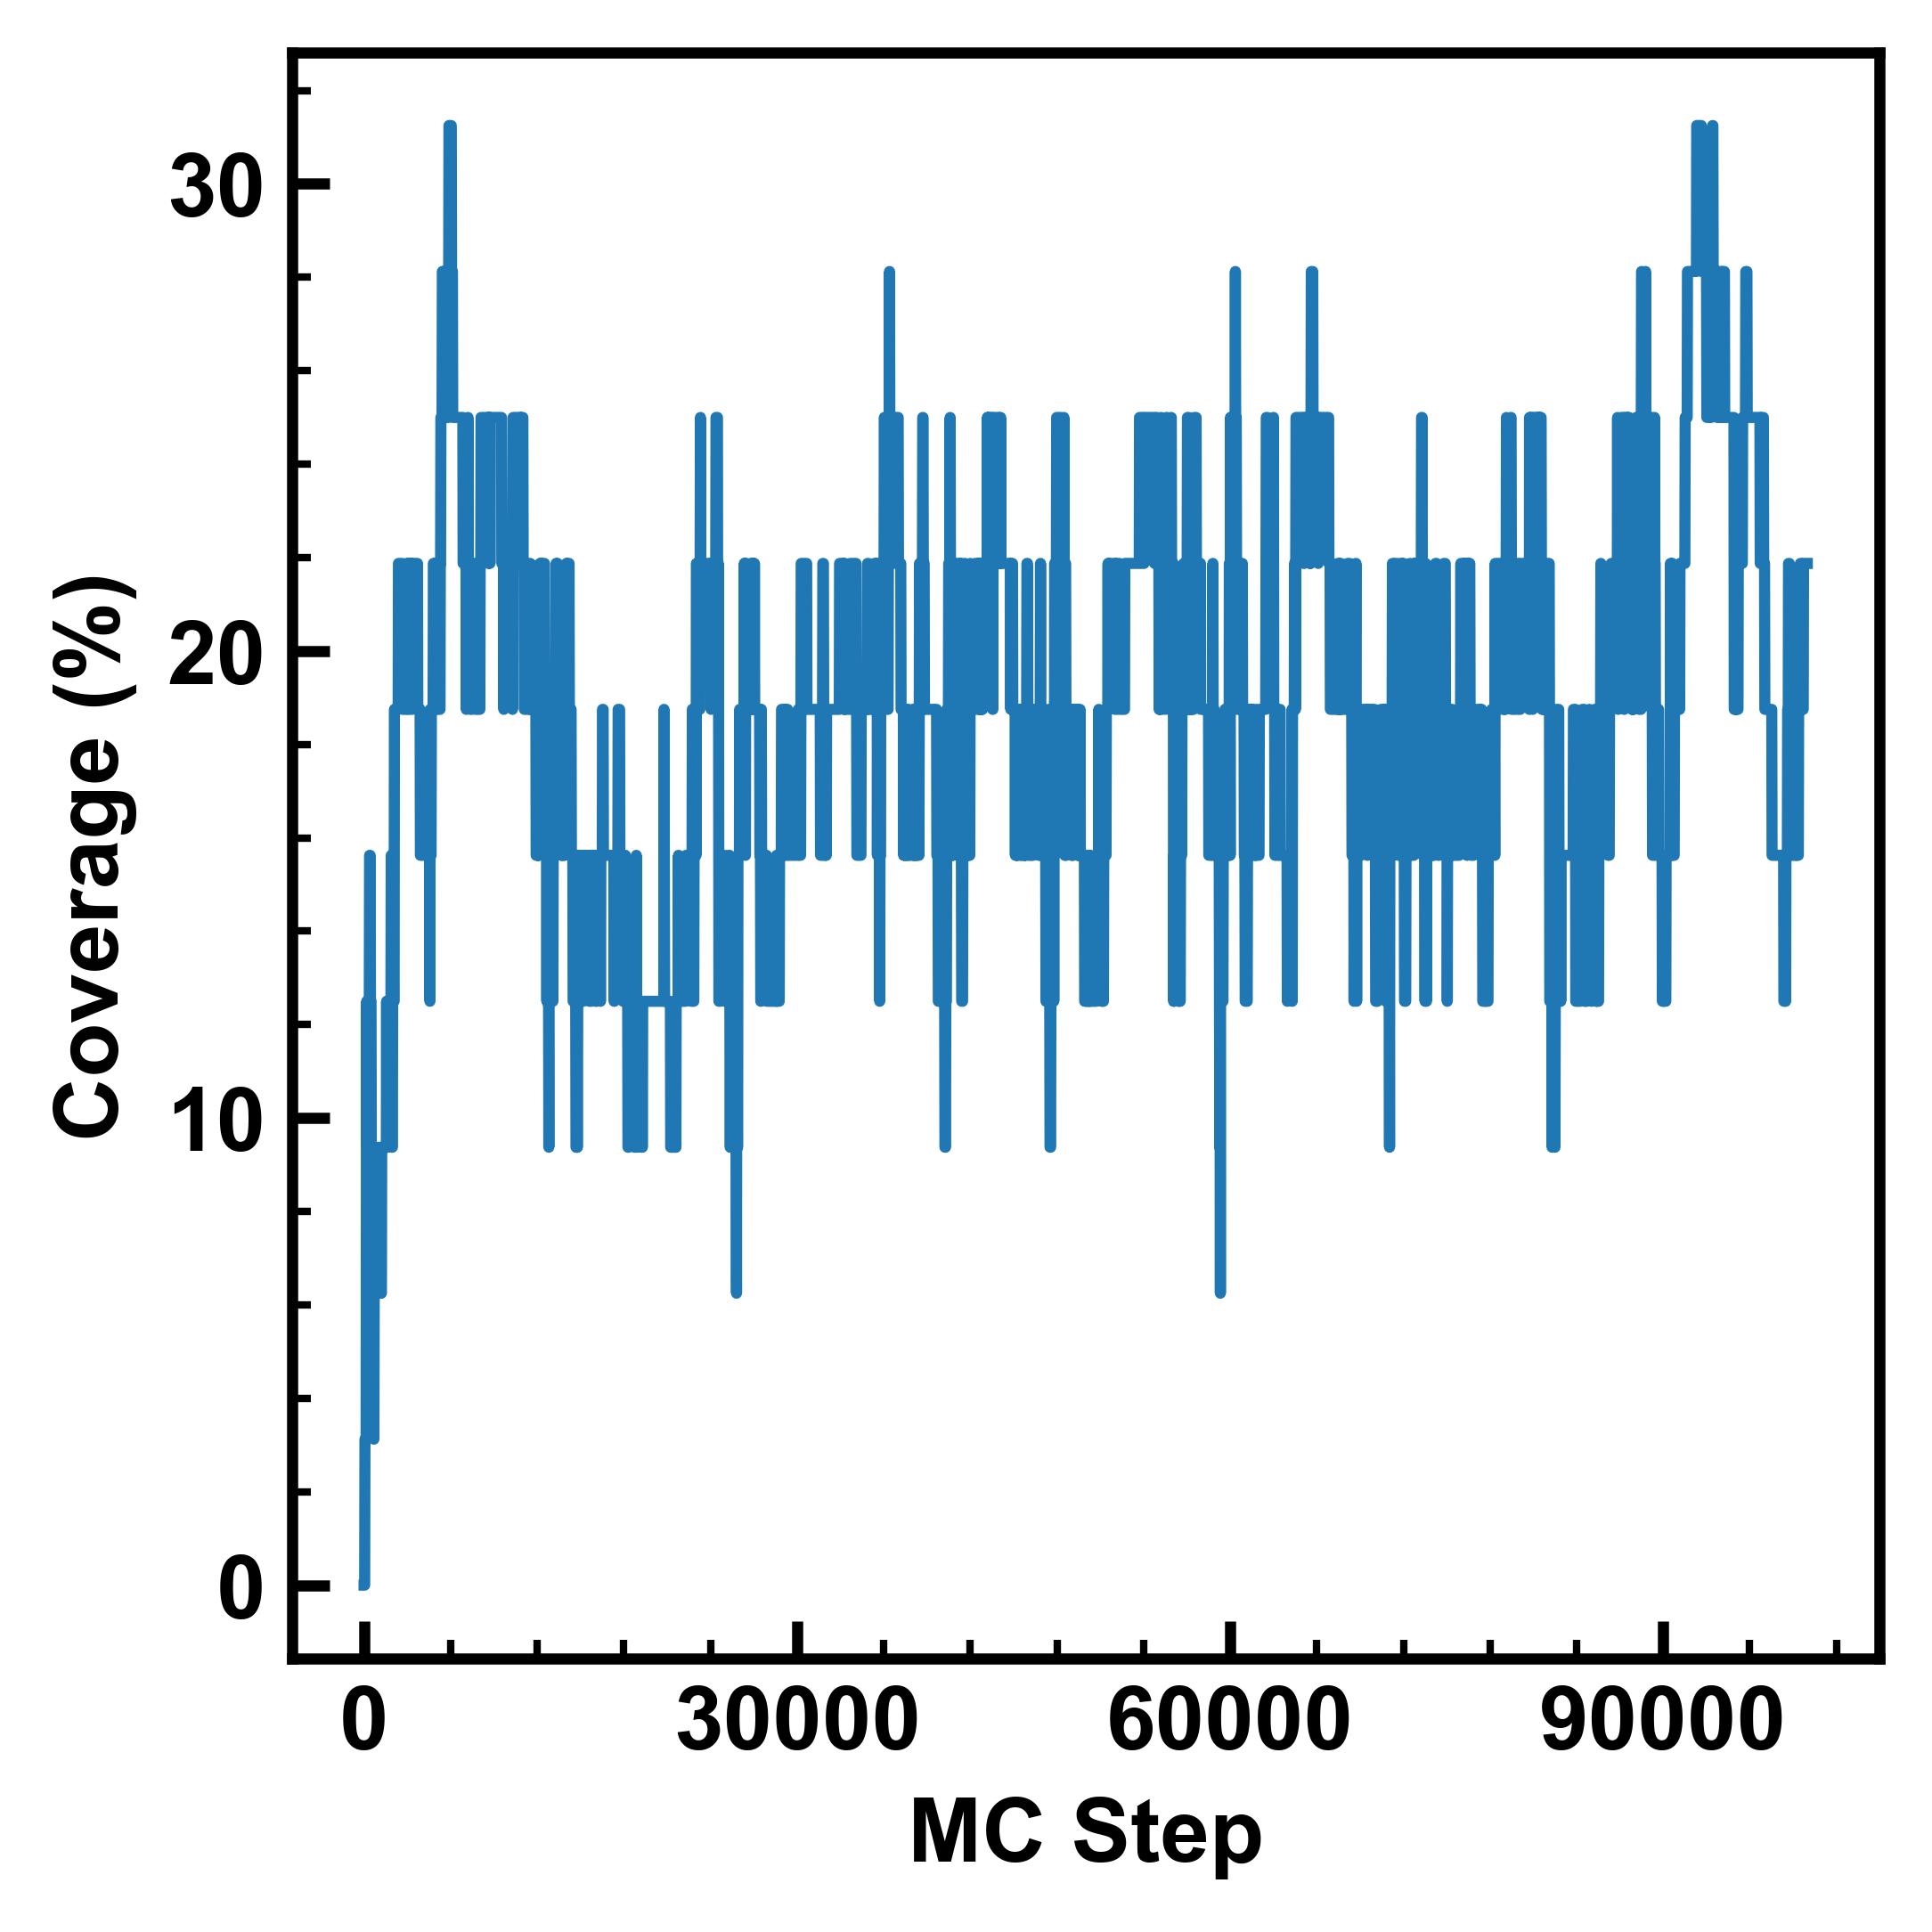

In [ ]:
fig, axs = plt.subplot_mosaic(
    [['a)'],], 
    figsize=(3.5, 3.5), dpi=600, 
    sharex = False, sharey = True, 
    layout="constrained"
    )

coverage = np.load("/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/gcmc/nh3-Pt/coverage/coverage.npy")
step = np.arange(len(coverage)) * 20

avg = np.mean(coverage[len(coverage)//2:])
std = np.std(coverage[len(coverage)//2:]) 

print(f"Coverage: {avg} +/- {std}")

axs["a)"].plot(step,coverage)
axs["a)"].set_xlabel(r'MC Step')
axs["a)"].set_ylabel(r'Coverage (%)')

for key, value in axs.items():
    set_ticks(axs[key], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 4)

save_figure(fig, prefix="coverage-powerpoint")

X: 489.006260566766 +/- 161.7907296497186
X: 446.1176896432377 +/- 136.7732900567716
X: 407.2992640166115 +/- 119.76208993945585


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


X: 401.921612696935 +/- 141.56267968243748


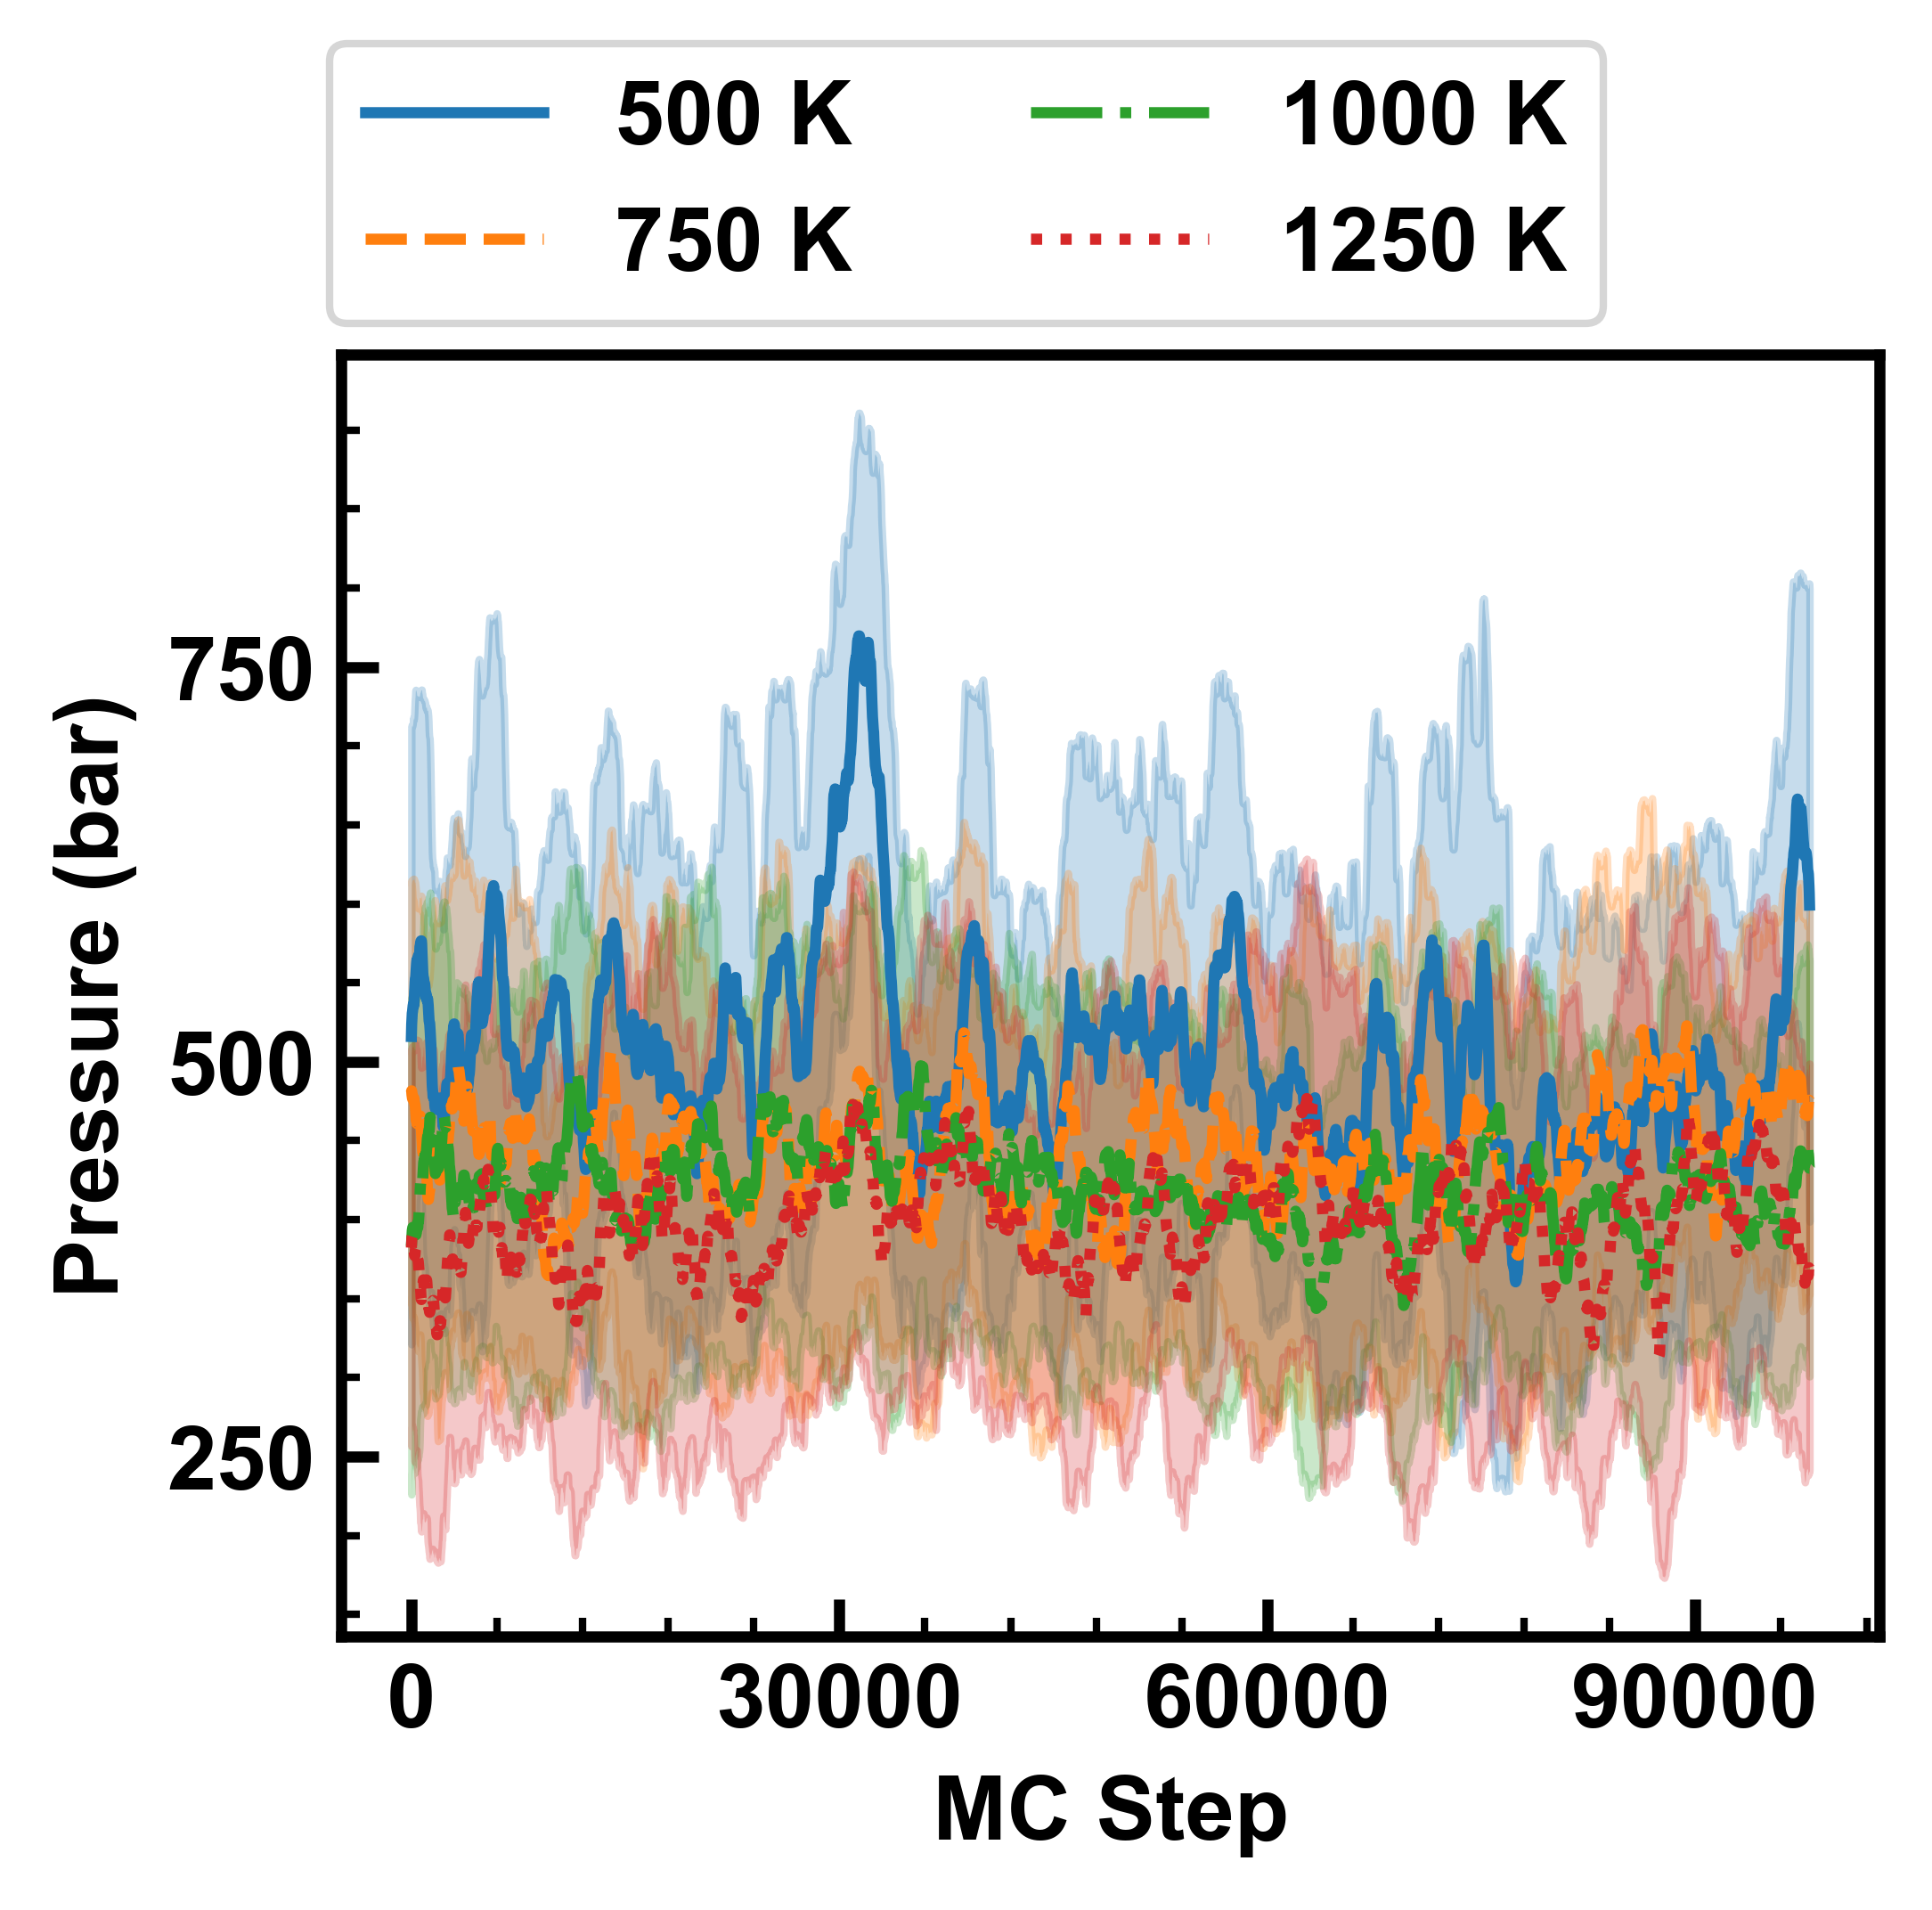

In [ ]:
fig, axs = plt.subplot_mosaic(
    [['a)'],], 
    figsize=(3.5, 3.5), dpi=600, 
    sharex = False, sharey = True, 
    layout="constrained"
    )



def plot_moving(ax, array, label, linestyle, color, window = 100):
    avg = moving_average(array, window, mode = "vaid")
    #std = moving_std(array, window)

    std =  moving_std_manual(array, window)
    steps = np.arange(len(avg)) * 20
    ax.plot(steps, avg, label = label, linestyle = linestyle, color = color)
    ax.fill_between(steps, avg - std, avg + std, color=color, alpha=0.25)

    avg = np.mean(array[len(array)//2:])
    std = np.std(array[len(array)//2:]) 

    print(f"X: {avg} +/- {std}")


prefix = "/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/gcmc/nh3-Pt/"



pressure = np.load(f"{prefix}/B3_T500/pressure/NH3.pressure_bar.npy")
plot_moving(axs["a)"], pressure, "500 K", "solid", colors[0], window = 100)


pressure = np.load(f"{prefix}/B3_T750/pressure/NH3.pressure_bar.npy")
plot_moving(axs["a)"], pressure, "750 K", "dashed", colors[1], window = 100)


pressure = np.load(f"{prefix}/B3_T1000/pressure/NH3.pressure_bar.npy")
plot_moving(axs["a)"], pressure, "1000 K", "dashdot", colors[2], window = 100)

pressure = np.load(f"{prefix}/B3_T1250/pressure/NH3.pressure_bar.npy")
plot_moving(axs["a)"], pressure, "1250 K", "dotted", colors[3], window = 100)


axs["a)"].set_xlabel(r'MC Step')
axs["a)"].set_ylabel(r'Pressure (bar)')

for key, value in axs.items():
    set_ticks(axs[key], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 4)

fig.legend(loc = "outside upper center", ncols = 2)
save_figure(fig, prefix="pressure")



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Coverage at 500 K: 40.32625 +/- 1.0899964162785123
Coverage at 750 K: 30.525 +/- 3.5341194094144583
Coverage at 1000 K: 19.785 +/- 4.156962532907893
Coverage at 1250 K: 9.7775 +/- 4.184479507656836


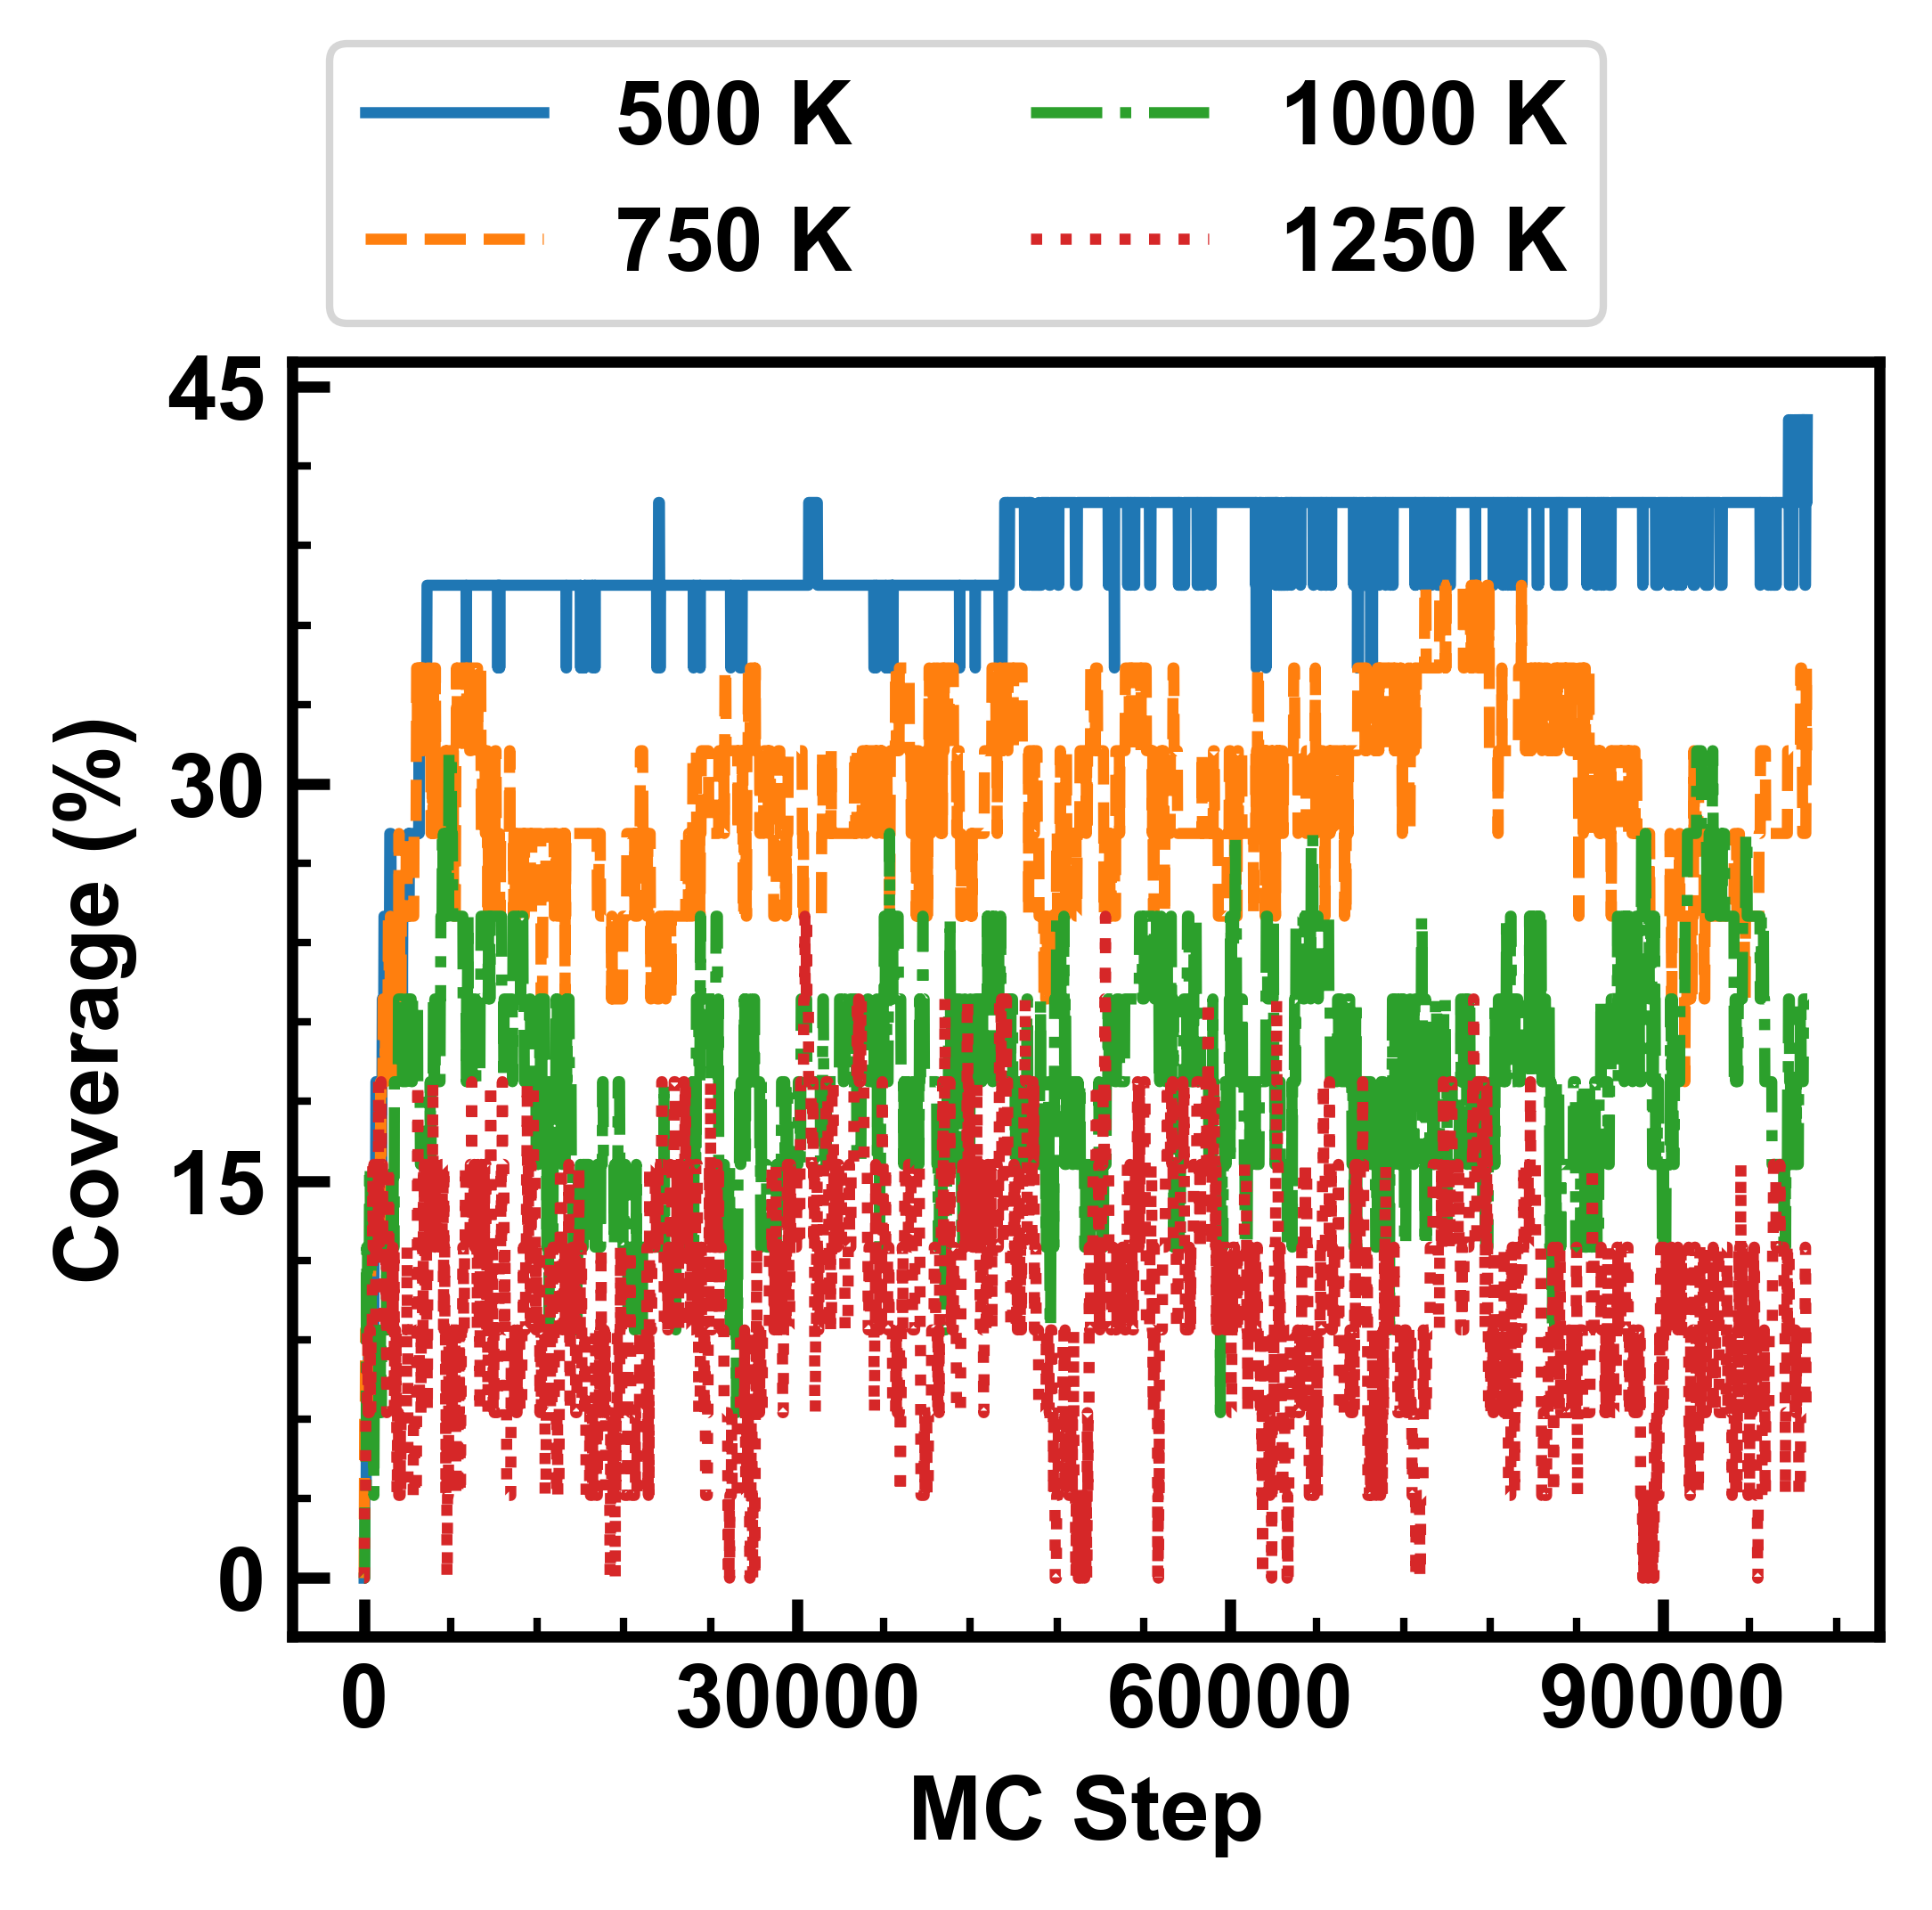

In [ ]:
fig, axs = plt.subplot_mosaic(
    [['a)'],], 
    figsize=(3.5, 3.5), dpi=600, 
    sharex = False, sharey = True, 
    layout="constrained"
    )



prefix = "/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/gcmc/nh3-Pt/"

systems = ["B3_T500", "B3_T750", "B3_T1000", "B3_T1250"]
labels = ["500 K", "750 K", "1000 K", "1250 K"]
linestyles = ["solid", "dashed", "dashdot", "dotted"]


for i in range(4):
    coverage = np.load(f"{prefix}/{systems[i]}/coverage/coverage.npy")
    step = np.arange(len(coverage)) * 20
    avg = np.mean(coverage[len(coverage)//2:])
    std = np.std(coverage[len(coverage)//2:]) 
    print(f"Coverage at {labels[i]}: {avg} +/- {std}")
    
    axs["a)"].plot(step, coverage, label = labels[i], linestyle = linestyles[i], color = colors[i])



axs["a)"].set_xlabel(r'MC Step')
axs["a)"].set_ylabel(r'Coverage (%)')

for key, value in axs.items():
    set_ticks(axs[key], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 4)


fig.legend(loc = "outside upper center", ncols = 2)
save_figure(fig, prefix="coverage-powerpoint")

Coverage at 500 K: 40.32625 +/- 1.0899964162785123
Coverage at 750 K: 30.525 +/- 3.5341194094144583
Coverage at 1000 K: 19.785 +/- 4.156962532907893
Coverage at 1250 K: 9.7775 +/- 4.184479507656836


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


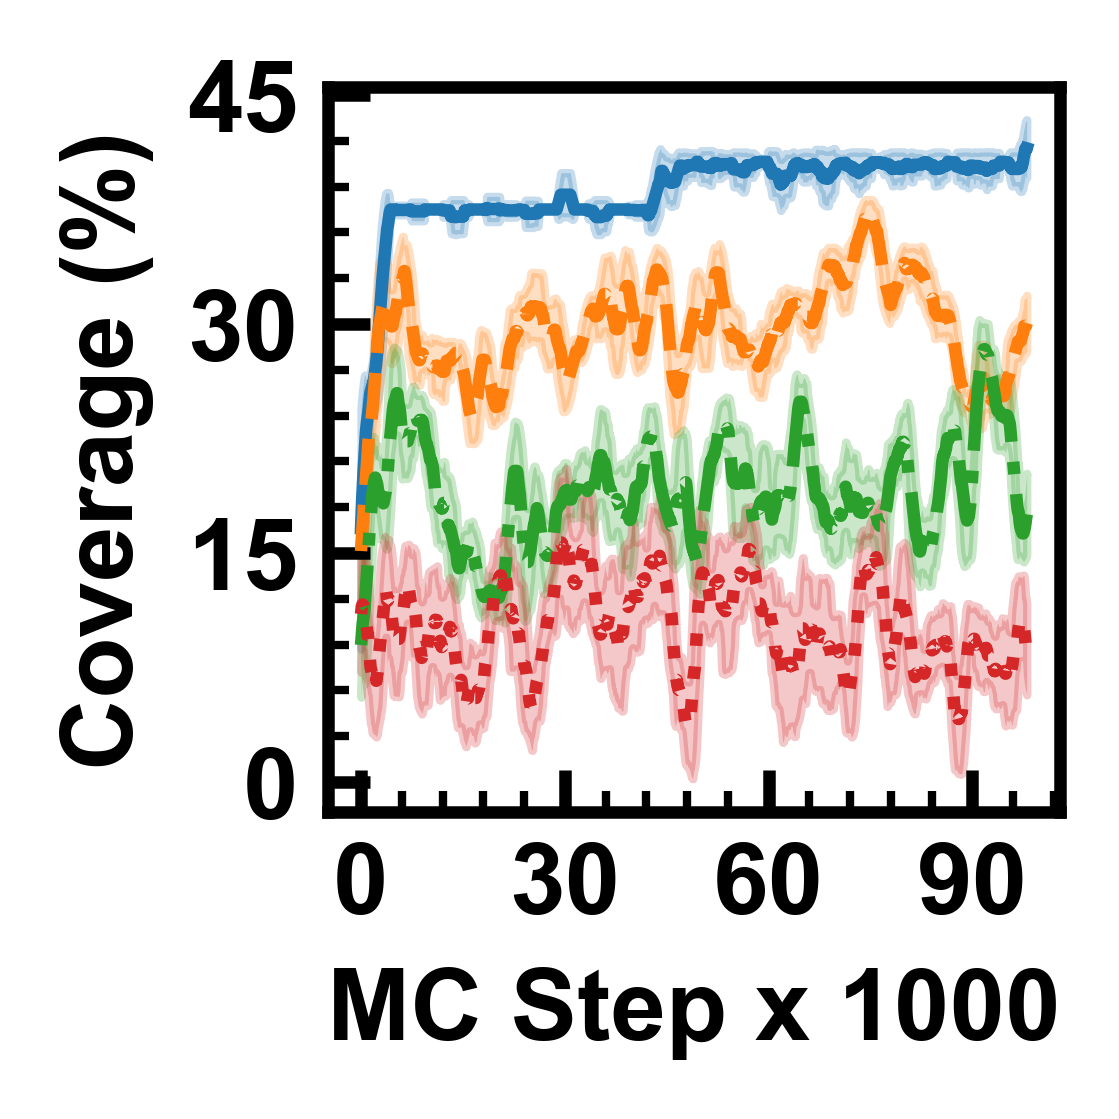

In [27]:
fig, axs = plt.subplot_mosaic(
    [['a)'],], 
    figsize=(3.5/2.0, 3.5/2.0), dpi=600, 
    sharex = False, sharey = True, 
    layout="constrained"
    )

def plot_moving(ax, array, label, linestyle, color, window = 100):
    avg = moving_average(array, window, mode = "vaid")
    #std = moving_std(array, window)
    std =  moving_std_manual(array, window)
    steps = np.arange(len(avg)) * 20
    ax.plot(steps / 1000.0, avg, label = label, linestyle = linestyle, color = color)
    ax.fill_between(steps / 1000.0, avg - std, avg + std, color=color, alpha=0.25)



    

prefix = "/Volumes/Woody_Seagate_Desktop_Drive/Woody/Projects/SCGSR/ASE-MC-Development/gcmc/nh3-Pt/"

systems = ["B3_T500", "B3_T750", "B3_T1000", "B3_T1250"]
labels = ["500 K", "750 K", "1000 K", "1250 K"]
linestyles = ["solid", "dashed", "dashdot", "dotted"]
#linestyles = ["solid", "solid", "solid", "solid"]

for i in range(4):
    coverage = np.load(f"{prefix}/{systems[i]}/coverage/coverage.npy")
    step = np.arange(len(coverage)) * 20
    avg = np.mean(coverage[len(coverage)//2:])
    std = np.std(coverage[len(coverage)//2:]) 
    print(f"Coverage at {labels[i]}: {avg} +/- {std}")

    plot_moving(axs["a)"], coverage, labels[i], linestyles[i], colors[i], window = 100) 
    



axs["a)"].set_xlabel(r'MC Step x 1000')
axs["a)"].set_ylabel(r'Coverage (%)')

for key, value in axs.items():
    set_ticks(axs[key], xlinear=False, ylinear=False, xmax=True, ymax=True, yticks = 4, xticks = 4)




#fig.legend(loc = "outside upper center", ncols = 2)
save_figure(fig, prefix="coverage-paper")